# Tutorial on inference with SPEXAI

This tutorial explains how you can use SPEXAI to fit observered spectra from a FITS file.

In [577]:
%load_ext autoreload
%autoreload 2 
%aimport spexai.inference

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

import numpy as np
import pickle
#from spexai.inference import SingleTemp, TwoTemp, TempDist
#from spexai.inference import CombinedModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fitting an One-Temperature Model

Simulated data or real data can be model with a one temperuture model by  ```Fit```

The paramater that are fitted are the 
- Temperature in KeV  ```temp``` (between 0.2 and 10 KeV)
- Metalicity [solar] ```met```  (larger than 0)
- Turbulent velocity in km/sec ```vel``` (between 0 and 600 km/sec)
- Redshift in log10(z) ```logz``` (between -10 and 1)
- Normalisation ```norm``` (between 1e5 and 1e15)

Additional parameter(s)
- Single element ```X``` abundace ratio with respect to Iron ```ZX```, where ```X``` is tha atom number (larger then 0)

The intial guess with there standard diviation of all the parameters that are fitted can be put into the dictiornary of the ```prior```.

In [209]:
#intial guess and prior for fit
prior = {
        'temp': {'mu': 5,    'sigma': 2},
        'met' : {'mu': 1,    'sigma': .3},
        'vel' : {'mu': 100,  'sigma': 50},
        'logz': {'mu': -3,   'sigma': 1},
        'norm': {'mu': 1e4, 'sigma':1e3}
        }

The ensemble samper can be intialized with ```nwalkers``` and ```nsteps``` for the walker to go through, ```prior``` indicates the intial values for the parameters and there Gaussion prior in the likelihood, other parameter that can be initialized are the Luminosity Distance in m and the energy interval of the spectrum in KeV (```e_min``` > 0.1; ```e_max``` < 25).

```fdir_nn``` is the file directory to the trained neural networks and should match the path on your device.

In [4]:
#initialize thes
fit = Fit(50, 800, prior, Luminosity_Distance=1e25, 
          fdir_nn='/Users/daniela/work/repositories/spexai/neuralnetworks/', 
          e_max=15)

Using cpu


### Reading in the FITS files

To be able to fit real data the response of the telescope can be read in by the FITS file, for the Response Matrix File (RMF), effective area response file (ARF).

The data used for fitting can be read in from a FITS file of the observed data ```Fit.load_data```, or can be simulated by the model with ```Fit.sim_data(params)``` here ```params``` is a dictornary with the parameter names and there values.

In addition the response files there is a sparse matrix (```make_sparsex```) used for convulation that implements line broadening to the spectra. The speed an accuracy of the line broadening is strongly dependent on the kernel size of the convulolution ```n``` and the default ```n=300```, increasing ```n``` will make the line-broading more accurete but will also segnifcanly impact the speed.

In [3]:
datadir = "/Users/daniela/work/data/xrism/"
nn_dir = "/Users/daniela/work/repositories/spexai/neuralnetworks/"

In [210]:
combined_model = spexai.inference.model.CombinedModel(lumdist=1e25, 
                                                      fdir_nn=nn_dir)

In [211]:
combined_model.load_matrices(datadir)
combined_model.sm_x_csr = combined_model.sm_x.to_sparse_csr()

In [212]:
'''This step can take a long time to run'''
#reading in the response matrix file
#combined_model.load_rm(datadir+'resolve_h5ev_2019a.rmf')

'This step can take a long time to run'

In [213]:
#reading in the effective area
combined_model.load_arf(datadir+'/resolve_pnt_spec_noGV_20190611.arf')

In [214]:
'''This step can take a long time to run'''
#initializing the sparse matrix for the convolution from line-broadening
#combined_model.load_sparsematrix_x(n=200)

'This step can take a long time to run'

The step loading the XRISM response file and constructing the sparse matrix for line-broadening can take ~several minutes. If you anticipate having to load these often, you can temporarily store the sparse `torch` tensors constructed in the methods above to Python `pickle` files for orders of magnitude faster loading. 

Note that long-term storage in `pickle` files is not recommended, because loading the binary format depends on the exact versions of the Python packages installed during the pickling process (i.e. if the Python environment changes, they might no longer load). 

**Important**: The code only saves/loads the response matrix and the sparse matrix for line broadening from file. The ARF needs to be loaded from its original file every time, but this operation is generally fast.

In [13]:
"""
combined_model.rm = rm
combined_model.arf = arf

combined_model.new_e_cent = new_e_cent
combined_model.new_e_diff = new_e_diff
#energy channels
combined_model.chan_cent = chan_cent
combined_model.chan_diff = chan_diff

combined_model.diag_index = diag_index
combined_model.rebin_interp = rebin_interp

combined_model.sm_x = sm_x

"""
rm = combined_model.rm
arf = combined_model.arf

new_e_cent = combined_model.new_e_cent
new_e_diff = combined_model.new_e_diff
#energy channels
chan_cent = combined_model.chan_cent
chan_diff = combined_model.chan_diff

diag_index = combined_model.diag_index
rebin_interp = combined_model.rebin_interp

sm_x = combined_model.sm_x

In [14]:

with open(datadir+"xrism_rmf.pkl", "wb") as f:
    pickle.dump(rm, f)
    
with open(datadir+"new_e_cent.pkl", "wb") as f:
    pickle.dump(new_e_cent, f)

with open(datadir+"chan_cent.pkl", "wb") as f:
    pickle.dump(chan_cent, f)
    
with open(datadir+"chan_diff.pkl", "wb") as f:
    pickle.dump(chan_diff, f)

with open(datadir+"diag_index.pkl", "wb") as f:
    pickle.dump(diag_index, f)
    
with open(datadir+"rebin_interp.pkl", "wb") as f:
    pickle.dump(rebin_interp, f)

with open(datadir+"sm_x.pkl", "wb") as f:
    pickle.dump(sm_x, f)

"""

with open(datadir+"xrism_rmf.pkl", "rb") as f:
    combined_model.rm = pickle.load(f)
    
with open(datadir+"new_e_cent.pkl", "rb") as f:
    combined_model.new_e_cent = pickle.load(f)

with open(datadir+"chan_cent.pkl", "rb") as f:
    combined_model.chan_cent = pickle.load(f)

with open(datadir+"chan_diff.pkl", "rb") as f:
    combined_model.chan_diff = pickle.load(f)

with open(datadir+"diag_index.pkl", "rb") as f:
    combined_model.diag_index = pickle.load(f)
    
with open(datadir+"rebin_interp.pkl", "rb") as f:
    combined_model.rebin_interp = pickle.load(f)

    
with open(datadir+"sm_x.pkl", "rb") as f:
    combined_model.sm_x = pickle.load(f)
"""

'\n\nwith open(datadir+"xrism_rmf.pkl", "rb") as f:\n    combined_model.rm = pickle.load(f)\n    \nwith open(datadir+"new_e_cent.pkl", "rb") as f:\n    combined_model.new_e_cent = pickle.load(f)\n\nwith open(datadir+"chan_cent.pkl", "rb") as f:\n    combined_model.chan_cent = pickle.load(f)\n\nwith open(datadir+"chan_diff.pkl", "rb") as f:\n    combined_model.chan_diff = pickle.load(f)\n\nwith open(datadir+"diag_index.pkl", "rb") as f:\n    combined_model.diag_index = pickle.load(f)\n    \nwith open(datadir+"rebin_interp.pkl", "rb") as f:\n    combined_model.rebin_interp = pickle.load(f)\n\n    \nwith open(datadir+"sm_x.pkl", "rb") as f:\n    combined_model.sm_x = pickle.load(f)\n'

### Simulating Data

We can simulated data from the model like so:

In [305]:
true_params = {'temp':5,'logz':-2, 'vel':100, 'met':1.2, 'norm':1e5, 'Z8':1.2, 'Z14':0.9}
exp_time = 50000

energy, counts, intensity = combined_model.simulate_data(true_params, ntemp=1, 
                                          dist_func=None, exp_time=exp_time, 
                                          e_min=None, e_max=None)

<IPython.core.display.Javascript object>


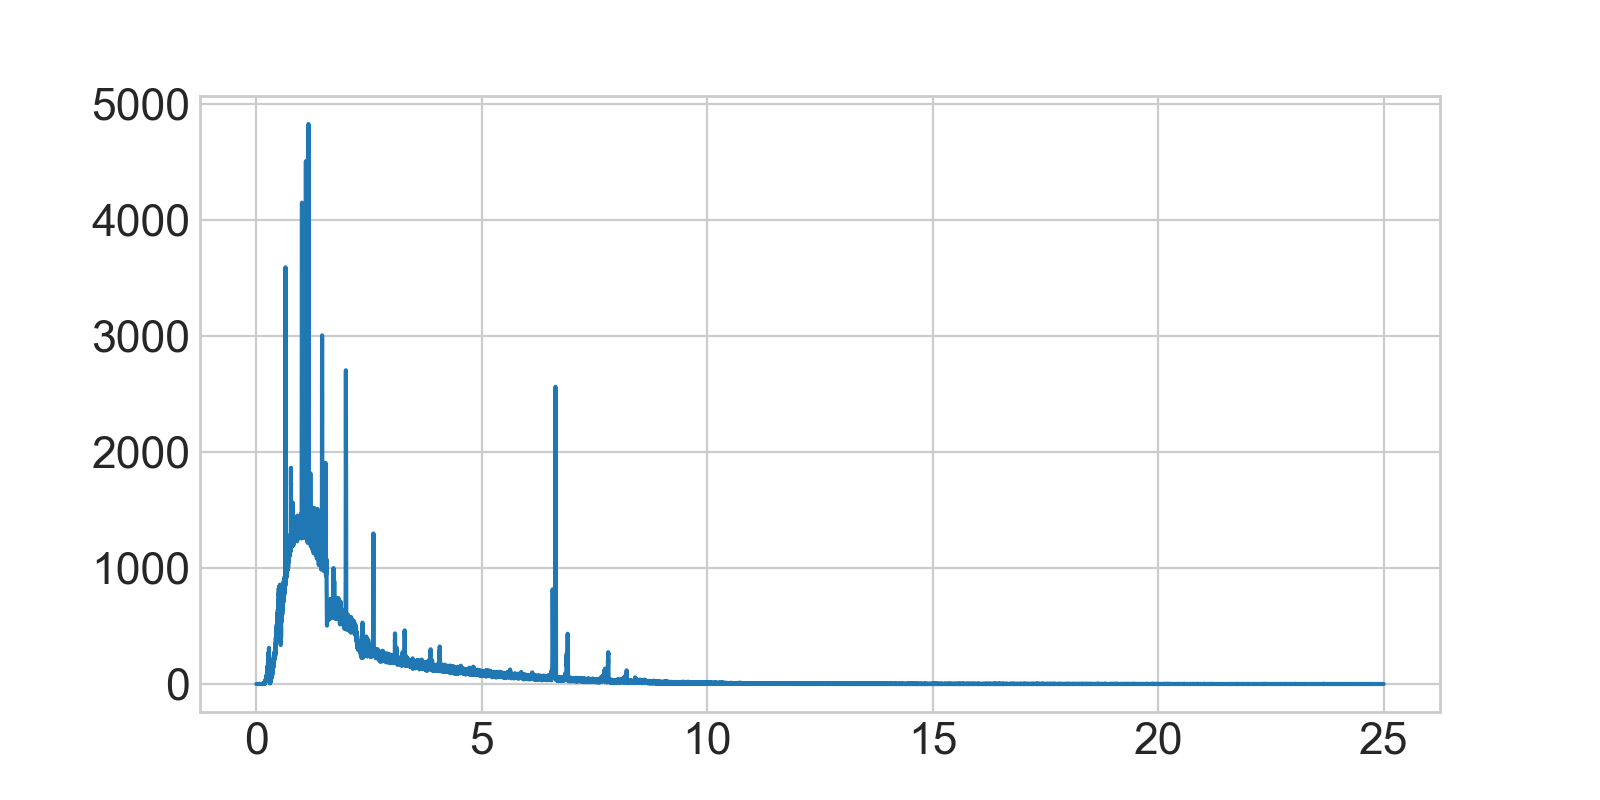

In [306]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(energy, counts)

When loading data from file, the relevant data arrays (`counts` and `exp_time`) will automatically be loaded into attributes of the `CombinedModel` class. For simulated data, we'll have to do this ourselves:

In [307]:
import torch

In [308]:
combined_model.counts = torch.Tensor(counts)
combined_model.exp_time = exp_time

### Building an object to do inference

In [309]:
prior

{'temp': {'mu': 5, 'sigma': 2},
 'met': {'mu': 1, 'sigma': 0.3},
 'vel': {'mu': 100, 'sigma': 50},
 'logz': {'mu': -3, 'sigma': 1},
 'norm': {'mu': 10000.0, 'sigma': 1000.0},
 'Z8': {'mu': 1, 'sigma': 0.3},
 'Z14': {'mu': 1, 'sigma': 0.3}}

In [310]:
#initialize thes
fit = spexai.inference.fit_new.SingleTemp(torch.Tensor(counts), combined_model, prior,
                 e_min=0.1, e_max=15.0, fdir_nn='neuralnetworks/')

Using cpu


In [312]:
true_params

{'temp': 5,
 'logz': -2,
 'vel': 100,
 'met': 1.2,
 'norm': 100000.0,
 'Z8': 1.2,
 'Z14': 0.9}

In [313]:
fit.log_posterior(params)

-90453.26326428443

This will break, because the dictionary defining the priors contains priors for fewer parameters than the parameters being put into the model. We'll need to either define a set of priors for the full parameters we need, but we can also add priors like so:


In [314]:
#names of aditional fitted parameters 
add_prior = {'Z8':{'mu':1, 'sigma':.3},'Z14':{'mu':1, 'sigma':.3}}
fit.add_prior(add_prior)

Let's try again:

In [315]:
fit.log_posterior(params)

-90453.26326428443

In [316]:
fit.log_prior(params)

-4065.333576784425

In [317]:
params

{'temp': 5,
 'logz': -2,
 'vel': 100,
 'met': 1.2,
 'norm': 100000.0,
 'Z8': 1.2,
 'Z14': 0.9}

In [318]:
fit.prior

{'temp': {'mu': 5, 'sigma': 2},
 'met': {'mu': 1, 'sigma': 0.3},
 'vel': {'mu': 100, 'sigma': 50},
 'logz': {'mu': -3, 'sigma': 1},
 'norm': {'mu': 10000.0, 'sigma': 1000.0},
 'Z8': {'mu': 1, 'sigma': 0.3},
 'Z14': {'mu': 1, 'sigma': 0.3}}

In [319]:
true_params

{'temp': 5,
 'logz': -2,
 'vel': 100,
 'met': 1.2,
 'norm': 100000.0,
 'Z8': 1.2,
 'Z14': 0.9}

In [320]:
#intial guess and prior for fit
prior_all = {
        'temp': {'mu': 5,    'sigma': 1},
        'met' : {'mu': 1.2,    'sigma': .1},
        'vel' : {'mu': 100,  'sigma': 50},
        'logz': {'mu': -2,   'sigma': 0.5},
        'norm': {'mu': 1e4, 'sigma':1e3},
        'Z8':{'mu':1.2, 'sigma':.1},
        'Z14':{'mu':0.9, 'sigma':.1}
        }

**TODO**:
* `norm` should be `lognorm`
* we probably don't want gaussian priors everywhere --> user should probably be able to just define a prior function that takes the parameters and returns the value for the prior
* `log_prob` needs a docstring!
* **IMPORTANT**: `sim_data` changes the state of a bunch of variables, which is BAD! I need to fix that! In general, there's a bunch of things that are entangled that shouldn't be!

In [321]:
test_params = [5.0, -2, 100, 1.2, 10000.0, 1.2, 0.9]

fit.log_prob(test_params, params.keys())

(-7331988.8335767845, [])

In [322]:
fit.log_likelihood(params)

array(-86387.93, dtype=float32)

In [323]:
fit.log_prior(params)

-4065.333576784425

## Modelling with Emcee, by hand

Something is not right with the modeling, so let's try to do this by hand:

In [335]:
true_params

{'temp': 5,
 'logz': -2,
 'vel': 100,
 'met': 1.2,
 'norm': 100000.0,
 'Z8': 1.2,
 'Z14': 0.9}

In [336]:
dict_abund = {}
for i in torch.arange(6,31):
    dict_abund[f'Z{i}'] = true_params['met']
    for key in true_params.keys():
        if key == f'Z{i}':
            dict_abund[f'Z{i}'] = true_params['met']*true_params[key]


In [344]:
temp = torch.tensor([true_params['temp']], dtype=torch.float32)

ymodel = combined_model.forward(temp, dict_abund, true_params["logz"], true_params["norm"], true_params["vel"])

In [348]:

yflux = ymodel * combined_model.chan_diff * combined_model.exp_time


In [349]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(energy, counts)
ax.plot(energy, yflux.detach().numpy())

<IPython.core.display.Javascript object>

Okay, that looks about right.


### Likelihood Function

In [352]:
true_params.keys()

dict_keys(['temp', 'logz', 'vel', 'met', 'norm', 'Z8', 'Z14'])

In [513]:
from scipy.special import gammaln as scipy_gammaln

def calculate_ymodel(param_list, model):
    temp = param_list[0]
    logz = param_list[1]
    vel = param_list[2]
    met = param_list[3]
    norm = param_list[4]
    z = {"Z8": param_list[5],
         "Z14": param_list[6]}

    #intialize list of abunadace
    dict_abund = {}
    for i in torch.arange(6,31):
        dict_abund[f'Z{i}'] = met
        for key in z.keys():
            if key == f'Z{i}':
                dict_abund[f'Z{i}'] = met*z[f'Z{i}']

    #counts = torch.tensor(counts, dtype=torch.float32)
    temp = torch.tensor([temp], dtype=torch.float32)
    ymodel = model.forward(temp, dict_abund, logz, norm, vel) 
    yflux = ymodel * combined_model.chan_diff * combined_model.exp_time + 1e-30

    return yflux

def loglikelihood(param_list, counts, model):
    yflux = calculate_ymodel(param_list, model)

    loglike = torch.sum(-yflux + counts * torch.log(yflux) - torch.special.gammaln(counts + 1.))
    
    if not torch.isfinite(loglike):
        return torch.tensor([-100000000000], dtype=torch.float32)
    else:
        return loglike


In [514]:
loglikelihood(param_list, combined_model.counts, combined_model)

tensor(-89893.0312, grad_fn=<SumBackward0>)

In [515]:
%timeit loglikelihood(param_list, combined_model.counts, combined_model)

231 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [516]:
param_list

[5, -2, 100, 1.2, 100000.0, 1.2, 0.9]

In [447]:
true_params

{'temp': 5,
 'logz': -2,
 'vel': 100,
 'met': 1.2,
 'norm': 100000.0,
 'Z8': 1.2,
 'Z14': 0.9}

In [448]:
def logprior(param_list):
    temp = torch.tensor([param_list[0]], dtype=torch.float32)
    logz = torch.tensor([param_list[1]], dtype=torch.float32)
    vel = torch.tensor([param_list[2]], dtype=torch.float32)
    met = torch.tensor([param_list[3]], dtype=torch.float32)
    norm = torch.tensor([param_list[4]], dtype=torch.float32)
    z = {"Z8": torch.tensor([param_list[5]], dtype=torch.float32),
         "Z14": torch.tensor([param_list[6]], dtype=torch.float32)}

    
    lp = 0
    lp += torch.distributions.Normal(5, 0.1).log_prob(temp)
    lp += torch.distributions.Normal(-2, 0.1).log_prob(logz)
    lp += torch.distributions.Normal(100, 10).log_prob(vel)
    lp += torch.distributions.Normal(1.0, 0.1).log_prob(met)
    lp += torch.distributions.Normal(1e5, 1e4).log_prob(norm)
    lp += torch.distributions.Normal(1.2, 0.1).log_prob(z["Z8"])
    lp += torch.distributions.Normal(0.9, 0.1).log_prob(z["Z14"])
    
    return lp
    

In [401]:
%timeit logprior(param_list)

699 µs ± 95.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [449]:
test_params = [5, -2, 100, 1.0, 100000.0, 1.2, 0.9]
print(f"prior: {logprior(test_params)}")
print(f"likelihood: {loglikelihood(test_params, combined_model.counts, combined_model)}")

prior: tensor([-6.4326])
likelihood: -96535.3984375


In [519]:
param_list_wrong = [5, -2, 100, 1.2, 100000.0, -1.2, 0.9]
loglikelihood(param_list_wrong, combined_model.counts, combined_model)

tensor([-1.0000e+11])

Okay, that seems to work. 

In [520]:
def logprob(param_list, counts, model):
    lp = logprior(param_list)
    if not np.isfinite(lp):
        return -np.inf
    
    ll = loglikelihood(param_list, counts, model)
    lpost = ll + lp
    return lpost.detach().numpy()

In [521]:
%timeit logprob(test_params, combined_model.counts, combined_model)

241 ms ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [522]:
logprob(test_params, combined_model.counts, combined_model)

array([-96541.83], dtype=float32)

### Maximum A Posteriori Estimation

In [523]:
def nll(*args):
    print(args[0])
    ll = -loglikelihood(*args).detach().numpy()
    print(ll)
    return ll

#nll = lambda *args: -loglikelihood(*args).detach().numpy()

In [524]:
start_pars = test_params + np.random.normal(size=len(test_params))

In [525]:
from scipy.optimize import minimize
soln = minimize(nll, start_pars, args=(combined_model.counts, combined_model), method="Powell")

[ 5.00975939e+00 -1.94505168e+00  1.01124841e+02  3.97533837e-01
  9.99980015e+04  1.85890686e+00  2.39289961e+00]
318745.3
[ 5.00975939e+00 -1.94505168e+00  1.01124841e+02  3.97533837e-01
  9.99980015e+04  1.85890686e+00  2.39289961e+00]
318745.3
[ 6.00975939e+00 -1.94505168e+00  1.01124841e+02  3.97533837e-01
  9.99980015e+04  1.85890686e+00  2.39289961e+00]
321987.7
[ 3.39172539e+00 -1.94505168e+00  1.01124841e+02  3.97533837e-01
  9.99980015e+04  1.85890686e+00  2.39289961e+00]
447229.7
[ 4.39172542e+00 -1.94505168e+00  1.01124841e+02  3.97533837e-01
  9.99980015e+04  1.85890686e+00  2.39289961e+00]
337676.78
[ 5.39172539e+00 -1.94505168e+00  1.01124841e+02  3.97533837e-01
  9.99980015e+04  1.85890686e+00  2.39289961e+00]
316379.5
[ 5.32746679e+00 -1.94505168e+00  1.01124841e+02  3.97533837e-01
  9.99980015e+04  1.85890686e+00  2.39289961e+00]
316367.06
[ 5.35478239e+00 -1.94505168e+00  1.01124841e+02  3.97533837e-01
  9.99980015e+04  1.85890686e+00  2.39289961e+00]
316354.78
[ 5.3

117097.06
[ 5.35478239e+00 -1.99962859e+00  5.75875630e+01  1.00326896e+00
  9.92609790e+04  1.63602059e+00  7.74865612e-01]
100451.555
[ 5.35478239e+00 -1.99962859e+00  5.75875630e+01  1.00326896e+00
  9.92609790e+04  1.63602059e+00  1.17083108e+00]
98682.93
[ 5.35478239e+00 -1.99962859e+00  5.75875630e+01  1.00326896e+00
  9.92609790e+04  1.63602059e+00  1.63761971e+00]
99577.664
[ 5.35478239e+00 -1.99962859e+00  5.75875630e+01  1.00326896e+00
  9.92609790e+04  1.63602059e+00  1.34912846e+00]
98721.875
[ 5.35478239e+00 -1.99962859e+00  5.75875630e+01  1.00326896e+00
  9.92609790e+04  1.63602059e+00  1.24142807e+00]
98647.34
[ 5.35478239e+00 -1.99962859e+00  5.75875630e+01  1.00326896e+00
  9.92609790e+04  1.63602059e+00  1.25294279e+00]
98648.08
[ 5.35478239e+00 -1.99962859e+00  5.75875630e+01  1.00326896e+00
  9.92609790e+04  1.63602059e+00  1.22991336e+00]
98648.35
[ 5.69980538e+00 -2.05420551e+00  1.40502851e+01  1.60900408e+00
  9.85239565e+04  1.41313431e+00  8.99565360e-02]
253

91726.48
[ 4.96147165e+00 -2.00022737e+00  9.49622765e+01  1.12912809e+00
  9.90577233e+04  1.63602059e+00  1.24142807e+00]
91726.445
[ 4.96147165e+00 -2.00022737e+00  9.49622765e+01  1.12912809e+00
  9.90555584e+04  1.63602059e+00  1.24142807e+00]
91726.43
[ 4.96147165e+00 -2.00022737e+00  9.49622765e+01  1.12912809e+00
  9.90555584e+04  2.63602059e+00  1.24142807e+00]
102640.59
[ 4.96147165e+00 -2.00022737e+00  9.49622765e+01  1.12912809e+00
  9.90555584e+04  1.79865872e-02  1.24142807e+00]
120161.36
[ 4.96147165e+00 -2.00022737e+00  9.49622765e+01  1.12912809e+00
  9.90555584e+04  1.01798661e+00  1.24142807e+00]
92940.94
[ 4.96147165e+00 -2.00022737e+00  9.49622765e+01  1.12912809e+00
  9.90555584e+04  2.01798659e+00  1.24142807e+00]
94289.94
[ 4.96147165e+00 -2.00022737e+00  9.49622765e+01  1.12912809e+00
  9.90555584e+04  1.44024757e+00  1.24142807e+00]
91317.516
[ 4.96147165e+00 -2.00022737e+00  9.49622765e+01  1.12912809e+00
  9.90555584e+04  1.42935018e+00  1.24142807e+00]
9131

90249.2
[ 4.98277621e+00 -2.00004064e+00  9.84093506e+01  1.18767694e+00
  9.90555584e+04  1.42165214e+00  1.01405049e+00]
90249.09
[ 4.98277621e+00 -2.00004064e+00  9.84093506e+01  1.18767694e+00
  9.90565584e+04  1.42165214e+00  1.01405049e+00]
90249.086
[ 4.98277621e+00 -2.00004064e+00  9.84093506e+01  1.18767694e+00
  9.90581764e+04  1.42165214e+00  1.01405049e+00]
90248.945
[ 4.98277621e+00 -2.00004064e+00  9.84093506e+01  1.18767694e+00
  9.90607945e+04  1.42165214e+00  1.01405049e+00]
90248.84
[ 4.98277621e+00 -2.00004064e+00  9.84093506e+01  1.18767694e+00
  9.90611930e+04  1.42165214e+00  1.01405049e+00]
90248.84
[ 4.98277621e+00 -2.00004064e+00  9.84093506e+01  1.18767694e+00
  9.90597945e+04  1.42165214e+00  1.01405049e+00]
90248.875
[ 4.98277621e+00 -2.00004064e+00  9.84093506e+01  1.18767694e+00
  9.90604125e+04  1.42165214e+00  1.01405049e+00]
90248.84
[ 4.98277621e+00 -2.00004064e+00  9.84093506e+01  1.18767694e+00
  9.90606035e+04  1.42165214e+00  1.01405049e+00]
90248.

89957.3
[ 5.01473108e+00 -2.00001712e+00  1.00596613e+02  1.22482777e+00
  9.90634926e+04  1.24528884e+00  9.19483422e-01]
89957.3
[ 5.01473108e+00 -2.00002664e+00  1.00596613e+02  1.22482777e+00
  9.90634926e+04  1.24528884e+00  9.19483422e-01]
89957.3
[ 5.01473108e+00 -2.00003252e+00  1.00596613e+02  1.22482777e+00
  9.90634926e+04  1.24528884e+00  9.19483422e-01]
89957.34
[ 5.01473108e+00 -2.00002300e+00  1.00596613e+02  1.22482777e+00
  9.90634926e+04  1.24528884e+00  9.19483422e-01]
89957.3
[ 5.01473108e+00 -2.00002075e+00  1.00596613e+02  1.22482777e+00
  9.90634926e+04  1.24528884e+00  9.19483422e-01]
89957.3
[ 5.01473108e+00 -2.00001936e+00  1.00596613e+02  1.22482777e+00
  9.90634926e+04  1.24528884e+00  9.19483422e-01]
89957.3
[ 5.01473108e+00 -2.00001839e+00  1.00596613e+02  1.22482777e+00
  9.90634926e+04  1.24528884e+00  9.19483422e-01]
89957.3
[ 5.01473108e+00 -2.00001839e+00  1.00596613e+02  1.22482777e+00
  9.90634926e+04  1.24528884e+00  9.19483422e-01]
89957.3
[ 5.014

90094.61
[ 4.99285798e+00 -2.00021011e+00  9.70124634e+01  1.16471646e+00
  9.93514218e+04  1.32913505e+00  9.85268850e-01]
90183.11
[ 5.00637630e+00 -2.00009162e+00  9.91997254e+01  1.20186730e+00
  9.93545019e+04  1.26067041e+00  9.48557700e-01]
89944.99
[ 5.01989462e+00 -1.99997314e+00  1.01386987e+02  1.23901813e+00
  9.93575820e+04  1.19220578e+00  9.11846552e-01]
89961.7
[ 5.01222822e+00 -2.00004033e+00  1.00146564e+02  1.21794944e+00
  9.93558352e+04  1.23103292e+00  9.32665895e-01]
89921.61
[ 5.01220319e+00 -2.00004055e+00  1.00142515e+02  1.21788065e+00
  9.93558295e+04  1.23115968e+00  9.32733864e-01]
89921.586
[ 5.00997752e+00 -2.00006006e+00  9.97824012e+01  1.21176410e+00
  9.93553224e+04  1.24243178e+00  9.38778032e-01]
89924.97
[ 5.01178669e+00 -2.00004420e+00  1.00075125e+02  1.21673603e+00
  9.93557346e+04  1.23326909e+00  9.33864943e-01]
89921.695
[ 5.01204329e+00 -2.00004195e+00  1.00116643e+02  1.21744122e+00
  9.93557931e+04  1.23196951e+00  9.33168100e-01]
89921.6

89921.54
[ 5.01209912e+00 -2.00004147e+00  1.00125511e+02  1.21759185e+00
  9.93558056e+04  1.23169191e+00  9.33019250e-01]
89921.54
[ 5.01209912e+00 -2.00004147e+00  1.00125511e+02  1.21759185e+00
  9.93558056e+04  1.23169191e+00  9.33019250e-01]
89921.54
[ 5.01209912e+00 -2.00004147e+00  1.00125511e+02  1.21759185e+00
  9.93558056e+04  1.23169191e+00  9.33019250e-01]
89921.54
[ 5.01209912e+00 -2.00004147e+00  1.00125511e+02  1.21759185e+00
  9.93558056e+04  1.23169191e+00  9.33019250e-01]
89921.54
[ 5.01209912e+00 -2.00004147e+00  1.00125511e+02  1.21759185e+00
  9.93558056e+04  1.23169191e+00  9.33019250e-01]
89921.54
[ 5.01209912e+00 -2.00004147e+00  1.00125511e+02  1.21759185e+00
  9.93558056e+04  1.23169191e+00  9.33019250e-01]
89921.54
[ 5.01209912e+00 -2.00004147e+00  1.00125511e+02  1.21759185e+00
  9.93558056e+04  1.23169191e+00  9.33019250e-01]
89921.54
[ 5.01209912e+00 -2.00004147e+00  1.00125511e+02  1.21759185e+00
  9.93558056e+04  1.23169191e+00  9.33019250e-01]
89921.54

89906.66
[ 5.01209912e+00 -2.00004147e+00  1.00477588e+02  1.21759185e+00
  9.95521279e+04  1.21565297e+00  9.23958393e-01]
89906.15
[ 5.01209912e+00 -2.00004147e+00  1.00477588e+02  1.21759185e+00
  9.95521279e+04  1.21395969e+00  9.23958393e-01]
89906.08
[ 5.01209912e+00 -2.00004147e+00  1.00477588e+02  1.21759185e+00
  9.95521279e+04  1.21335897e+00  9.23958393e-01]
89905.984
[ 5.01209912e+00 -2.00004147e+00  1.00477588e+02  1.21759185e+00
  9.95521279e+04  1.21354230e+00  9.23958393e-01]
89906.07
[ 5.01209912e+00 -2.00004147e+00  1.00477588e+02  1.21759185e+00
  9.95521279e+04  1.21317564e+00  9.23958393e-01]
89906.05
[ 5.01209912e+00 -2.00004147e+00  1.00477588e+02  1.21759185e+00
  9.95521279e+04  1.21335897e+00  9.23958393e-01]
89905.984
[ 5.02561744e+00 -1.99992298e+00  1.02664850e+02  1.25474268e+00
  9.95552079e+04  1.14489434e+00  8.87247244e-01]
90062.195
[ 4.99022601e+00 -2.00023318e+00  9.69385239e+01  1.15748054e+00
  9.95471442e+04  1.32413707e+00  9.83358280e-01]
90188

89887.68
[ 5.00279278e+00 -2.00000677e+00  9.97427642e+01  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.18623756e-01]
89886.46
[ 5.00279278e+00 -2.00000677e+00  1.00742764e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.18623756e-01]
89886.6
[ 5.00279278e+00 -2.00000677e+00  1.00142189e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.18623756e-01]
89886.31
[ 5.00279278e+00 -2.00000677e+00  1.00108127e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.18623756e-01]
89886.34
[ 5.00279278e+00 -2.00000677e+00  1.00218700e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.18623756e-01]
89886.35
[ 5.00279278e+00 -2.00000677e+00  1.00171414e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.18623756e-01]
89886.375
[ 5.00279278e+00 -2.00000677e+00  1.00160678e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.18623756e-01]
89886.38
[ 5.00279278e+00 -2.00000677e+00  1.00129178e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.18623756e-01]
89886.37

89886.28
[ 5.00279278e+00 -2.00000677e+00  1.00142189e+02  1.20176632e+00
  1.00005237e+05  1.20008891e+00  9.19398378e-01]
89886.28
[ 5.00279278e+00 -2.00000677e+00  1.00142189e+02  1.20176632e+00
  1.00005237e+05  1.20008891e+00  9.19398379e-01]
89886.28
[ 5.00279278e+00 -2.00000677e+00  1.00142189e+02  1.20176632e+00
  1.00005237e+05  1.20008891e+00  9.19398380e-01]
89886.28
[ 5.00279278e+00 -2.00000677e+00  1.00142189e+02  1.20176632e+00
  1.00005237e+05  1.20008891e+00  9.19398380e-01]
89886.28
[ 5.00279278e+00 -2.00000677e+00  1.00142189e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.19398380e-01]
89886.28
[ 5.00279278e+00 -2.00000677e+00  1.00142189e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.19398380e-01]
89886.28
[ 5.00279278e+00 -2.00000677e+00  1.00142189e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.19398380e-01]
89886.28
[ 5.00279278e+00 -2.00000677e+00  1.00142189e+02  1.20176632e+00
  1.00005237e+05  1.20008892e+00  9.19398380e-01]
89886.28

89886.33
[ 5.00309194e+00 -2.00000414e+00  1.00129958e+02  1.20258896e+00
  9.99714781e+04  1.20173169e+00  9.20146683e-01]
89886.49
[ 5.00282190e+00 -2.00000651e+00  1.00140999e+02  1.20184639e+00
  1.00001951e+05  1.20024881e+00  9.19471215e-01]
89886.38
[ 5.00275005e+00 -2.00000714e+00  1.00143936e+02  1.20164882e+00
  1.00010059e+05  1.19985427e+00  9.19291497e-01]
89886.31
[ 5.00277646e+00 -2.00000691e+00  1.00142856e+02  1.20172144e+00
  1.00007078e+05  1.19999929e+00  9.19357555e-01]
89886.32
[ 5.00280390e+00 -2.00000667e+00  1.00141734e+02  1.20179691e+00
  1.00003982e+05  1.20014999e+00  9.19426201e-01]
89886.3
[ 5.00278063e+00 -2.00000687e+00  1.00142686e+02  1.20173292e+00
  1.00006607e+05  1.20002221e+00  9.19367997e-01]
89886.336
[ 5.00278814e+00 -2.00000681e+00  1.00142379e+02  1.20175356e+00
  1.00005760e+05  1.20006344e+00  9.19386775e-01]
89886.35
[ 5.00279703e+00 -2.00000673e+00  1.00142015e+02  1.20177800e+00
  1.00004757e+05  1.20011224e+00  9.19409007e-01]
89886.32

In [526]:
test_params

[5, -2, 100, 1.0, 100000.0, 1.2, 0.9]

In [527]:
start_pars

array([ 5.00975939e+00, -1.94505168e+00,  1.01124841e+02,  3.97533837e-01,
        9.99980015e+04,  1.85890686e+00,  2.39289961e+00])

In [528]:
soln.x

array([ 5.00279333e+00, -2.00000676e+00,  1.00142166e+02,  1.20176784e+00,
        1.00005174e+05,  1.20009195e+00,  9.19399761e-01])

In [529]:
soln.message

'Optimization terminated successfully.'

In [530]:
yfit = calculate_ymodel(soln.x, combined_model)

<IPython.core.display.Javascript object>


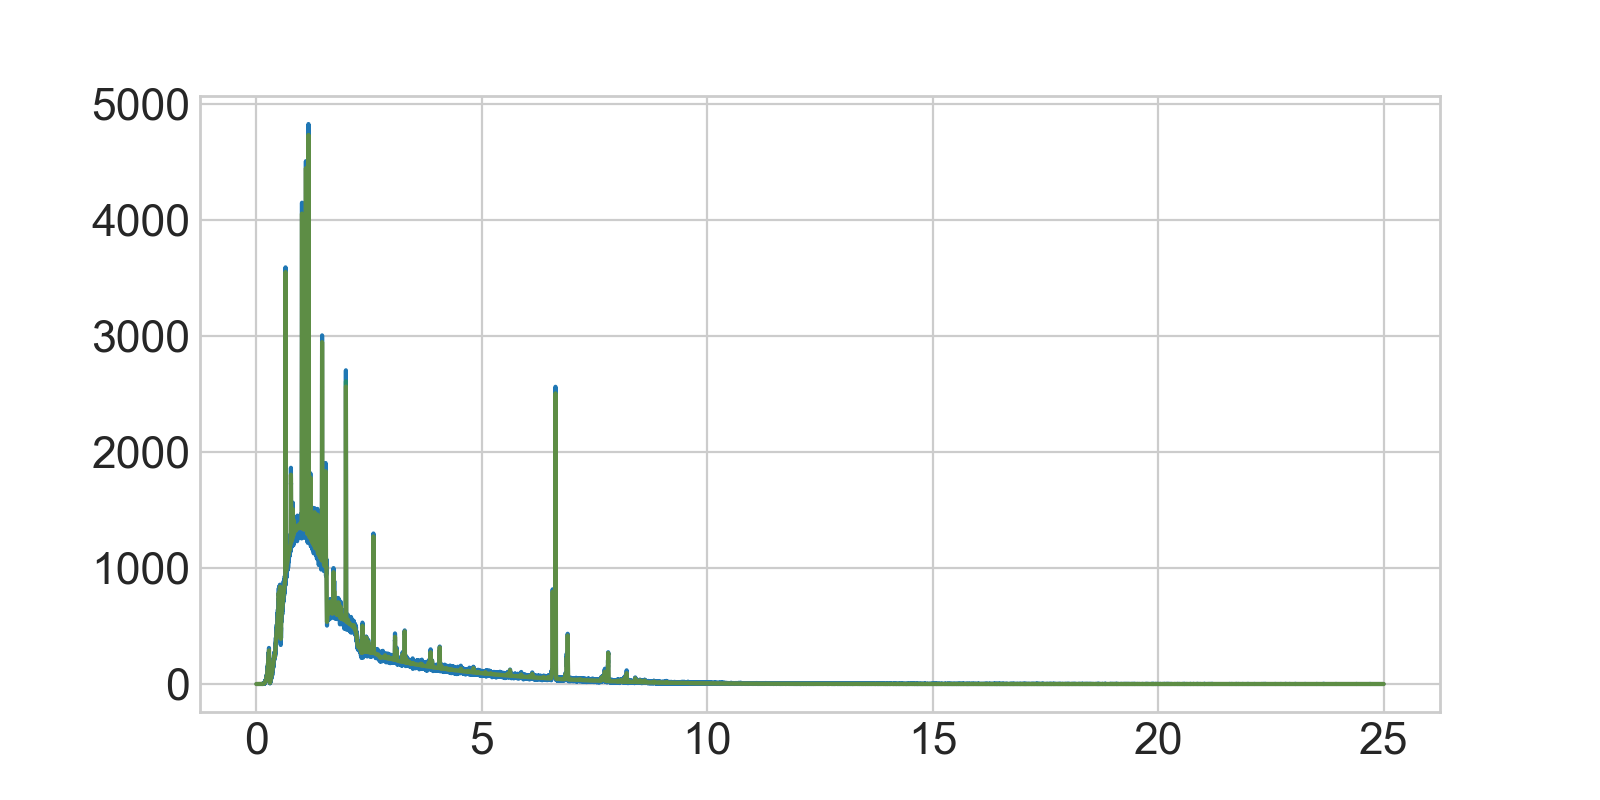

In [531]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(energy, counts)
ax.plot(energy, yflux.detach().numpy(), alpha=0.5)
ax.plot(energy, yfit.detach().numpy(), alpha=0.5)

### MCMC

Let's run MCMC. We'll do two runs. One, where we initialize the MCMC run from the prior, and a second one, where we initialize the MCMC run from the optimization result above.

In [556]:
ndim = len(test_params)
nwalkers = torch.tensor([20])

In [557]:
initial_pos = np.array([np.random.normal(5, 0.1, nwalkers),
               np.random.normal(-2, 0.1, nwalkers),
               np.random.normal(100, 10, nwalkers),
               np.random.normal(1.0, 0.1, nwalkers),
               np.random.normal(1e5, 1e4, nwalkers),
               np.random.normal(1.2, 0.1, nwalkers),
               np.random.normal(0.9, 0.1, nwalkers)
              ]).T


In [558]:
nwalkers, ndim = initial_pos.shape

In [559]:
import emcee

In [560]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, logprob, args=(combined_model.counts, combined_model))


In [567]:
sampler.run_mcmc(initial_pos, 1000, progress=True);

100%|███████████████████████████████████████████████| 1000/1000 [1:42:59<00:00,  6.18s/it]


In [564]:
samples.shape

(100, 20, 7)

['temp', 'logz', 'vel', 'met', 'norm', 'Z8', 'Z14']


<IPython.core.display.Javascript object>


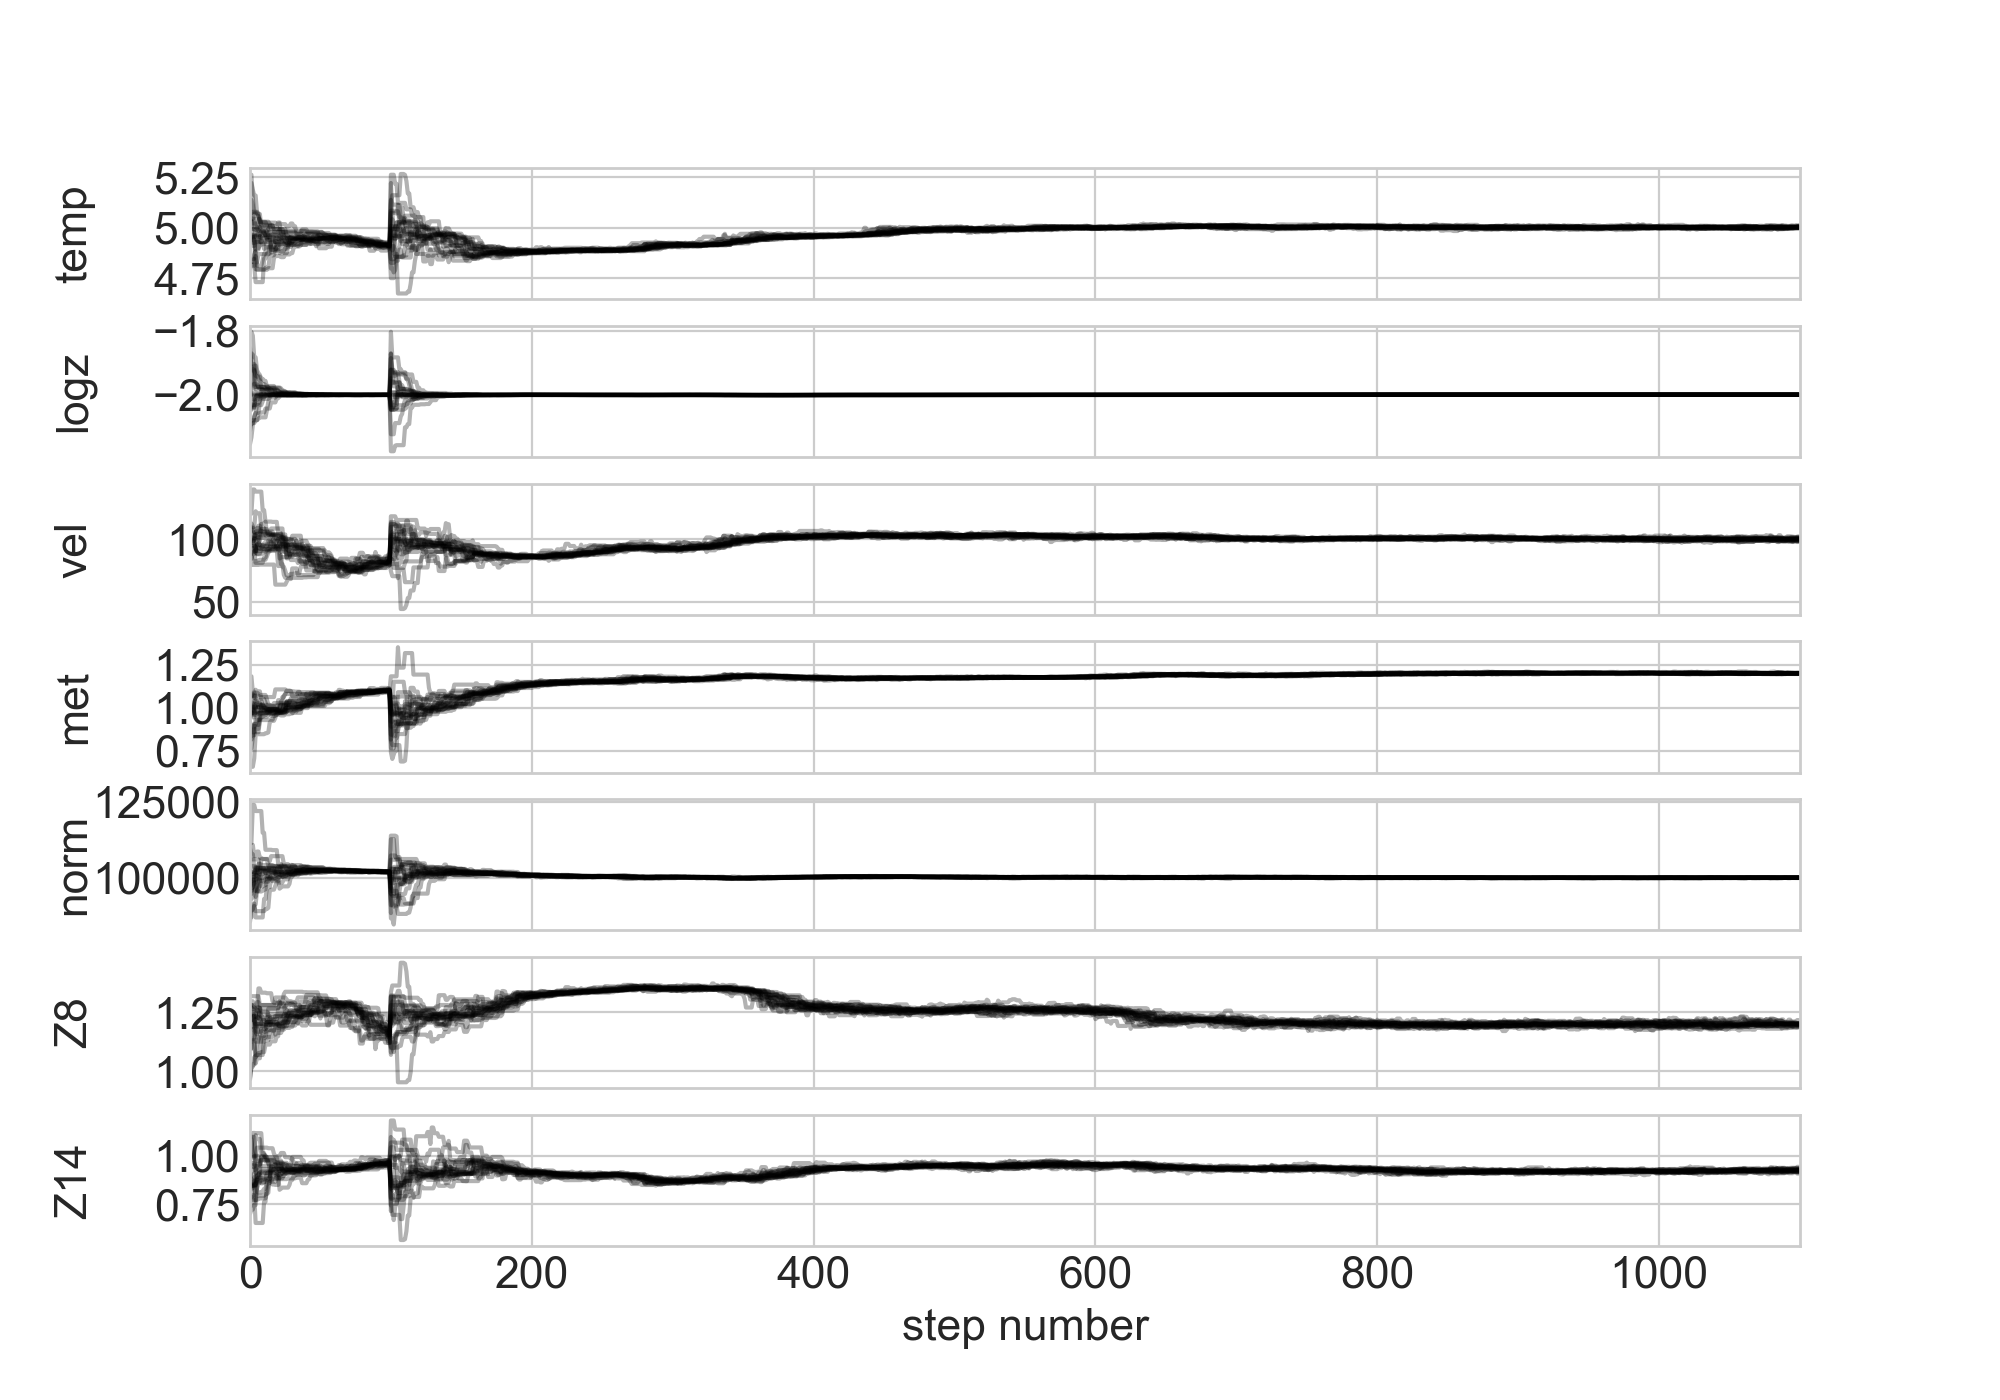

In [568]:
labels = list(params.keys())
print(labels)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [569]:
import corner

In [570]:
flat_samples = sampler.get_chain(discard=600, thin=10, flat=True)

<IPython.core.display.Javascript object>


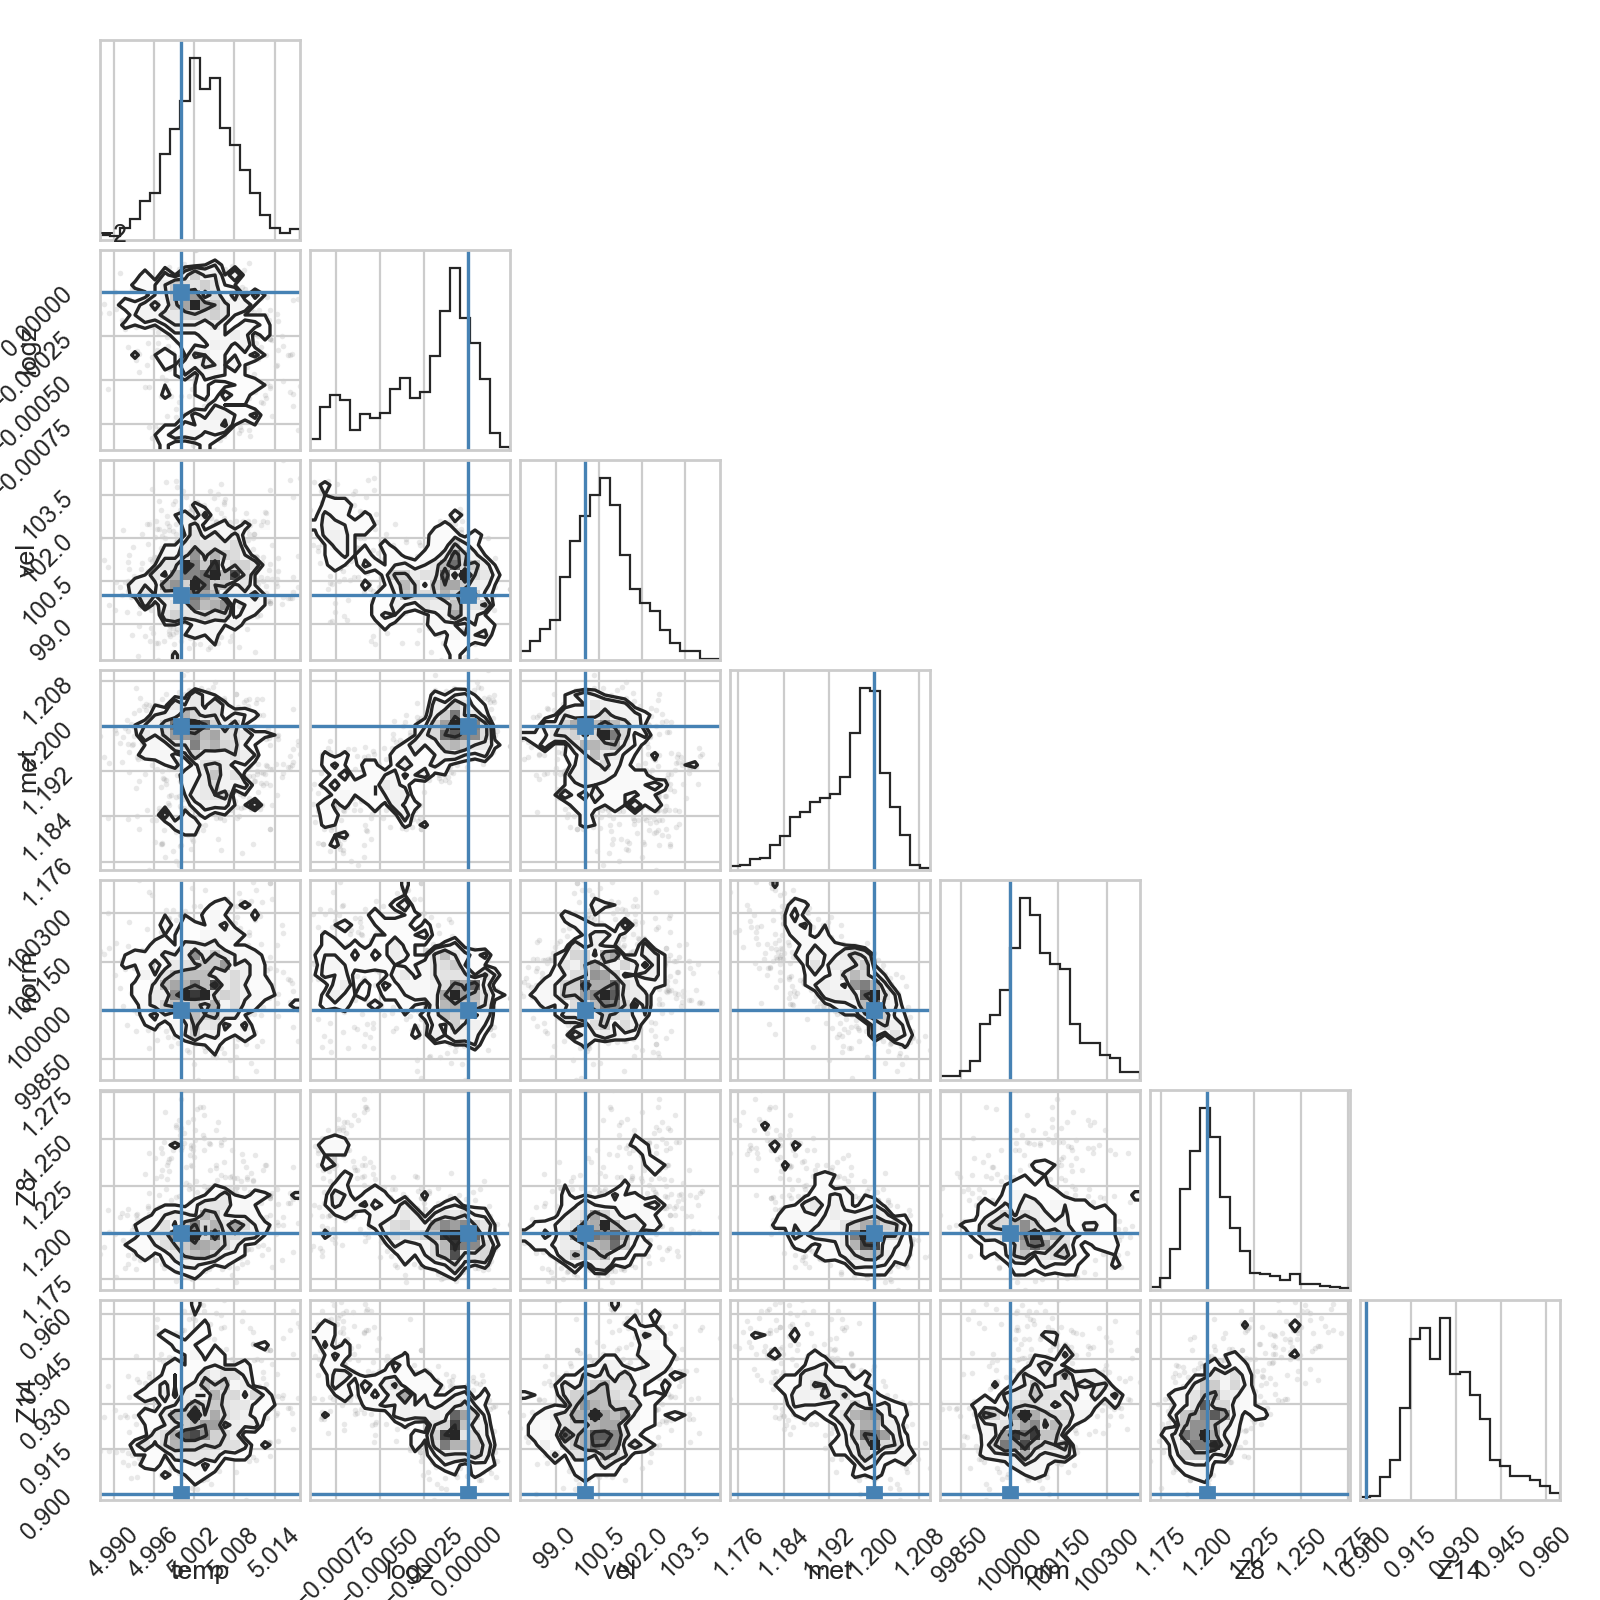

<IPython.core.display.Javascript object>


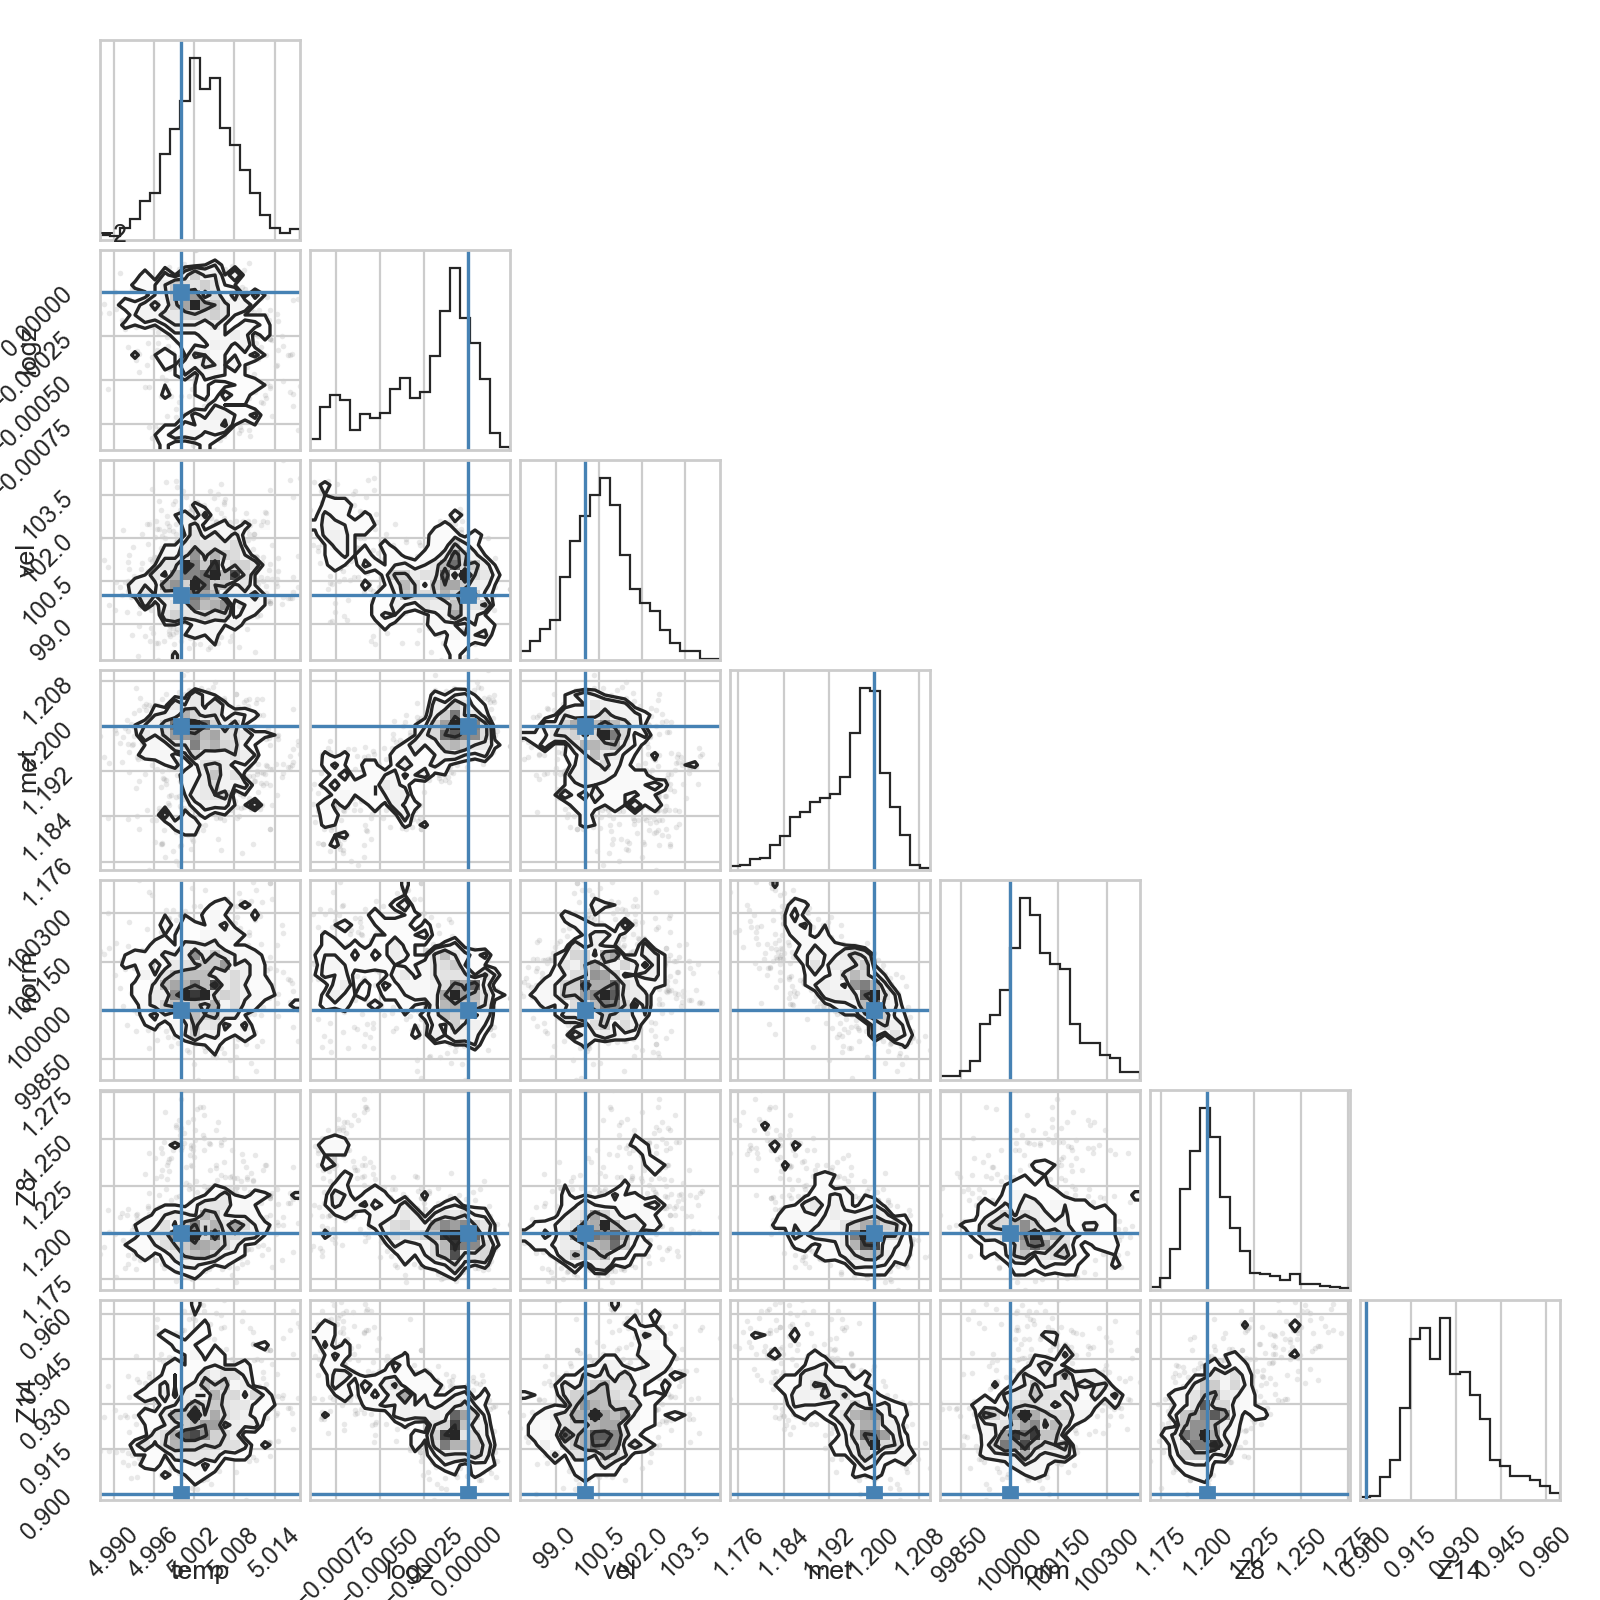

In [581]:
fig = plt.figure(figsize=(8,8))
corner.corner(flat_samples, fig=fig, labels = list(params.keys()),
              truths=list(true_params.values()))

#### MCMC, but from the Optimizer Solution

In [583]:
initial_pos = soln.x * np.random.normal(size=(nwalkers, ndim)) * 1e-3

In [584]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, logprob, args=(combined_model.counts, combined_model))


In [ ]:
sampler.run_mcmc(initial_pos, 1000, progress=True);

  2%|█                                                | 22/1000 [01:14<1:02:39,  3.84s/it]

### Modelling with Dynesty

In [256]:
fit.prior

{'temp': {'mu': 5, 'sigma': 2},
 'met': {'mu': 1, 'sigma': 0.3},
 'vel': {'mu': 100, 'sigma': 50},
 'logz': {'mu': -3, 'sigma': 1},
 'norm': {'mu': 10000.0, 'sigma': 1000.0},
 'Z8': {'mu': 1, 'sigma': 0.3},
 'Z14': {'mu': 1, 'sigma': 0.3}}

In [257]:
import dynesty


In [258]:
params.keys()

dict_keys(['temp', 'logz', 'vel', 'met', 'norm', 'Z8', 'Z14'])

In [260]:
import scipy.stats 

def loglike(param_values):
    keys = ['temp', 'logz', 'vel', 'met', 'norm', 'Z8', 'Z14']
    params = fit.flat_to_nested_dict(dict(zip(keys, param_values)))
    return float(fit.log_likelihood(params))

def prior_transform(u):
    
    keys = ['temp', 'logz', 'vel', 'met', 'norm', 'Z8', 'Z14']
    x = np.zeros_like(u)
  
    #intial guess and prior for fit
    prior = {
            'temp': {'mu': 5,    'sigma': 0.5},
            'met' : {'mu': 1,    'sigma': .2},
            'vel' : {'mu': 100,  'sigma': 10},
            'logz': {'mu': -3,   'sigma': 1},
            'norm': {'mu': 1e4, 'sigma':1e3},
            'Z8':{'mu':1, 'sigma':.2},
            'Z14':{'mu':1, 'sigma':.2}
        }
  
    for i,key in enumerate(keys):
        x[i] = scipy.stats.norm(prior[key]["mu"], prior[key]["sigma"]).ppf(u[i])
    
    return x

In [261]:
params

{'temp': 5,
 'logz': -2,
 'vel': 100,
 'met': 1.2,
 'norm': 10000.0,
 'Z8': 1.2,
 'Z14': 0.9}

Let's check whether the prior transform works correctly:

<IPython.core.display.Javascript object>


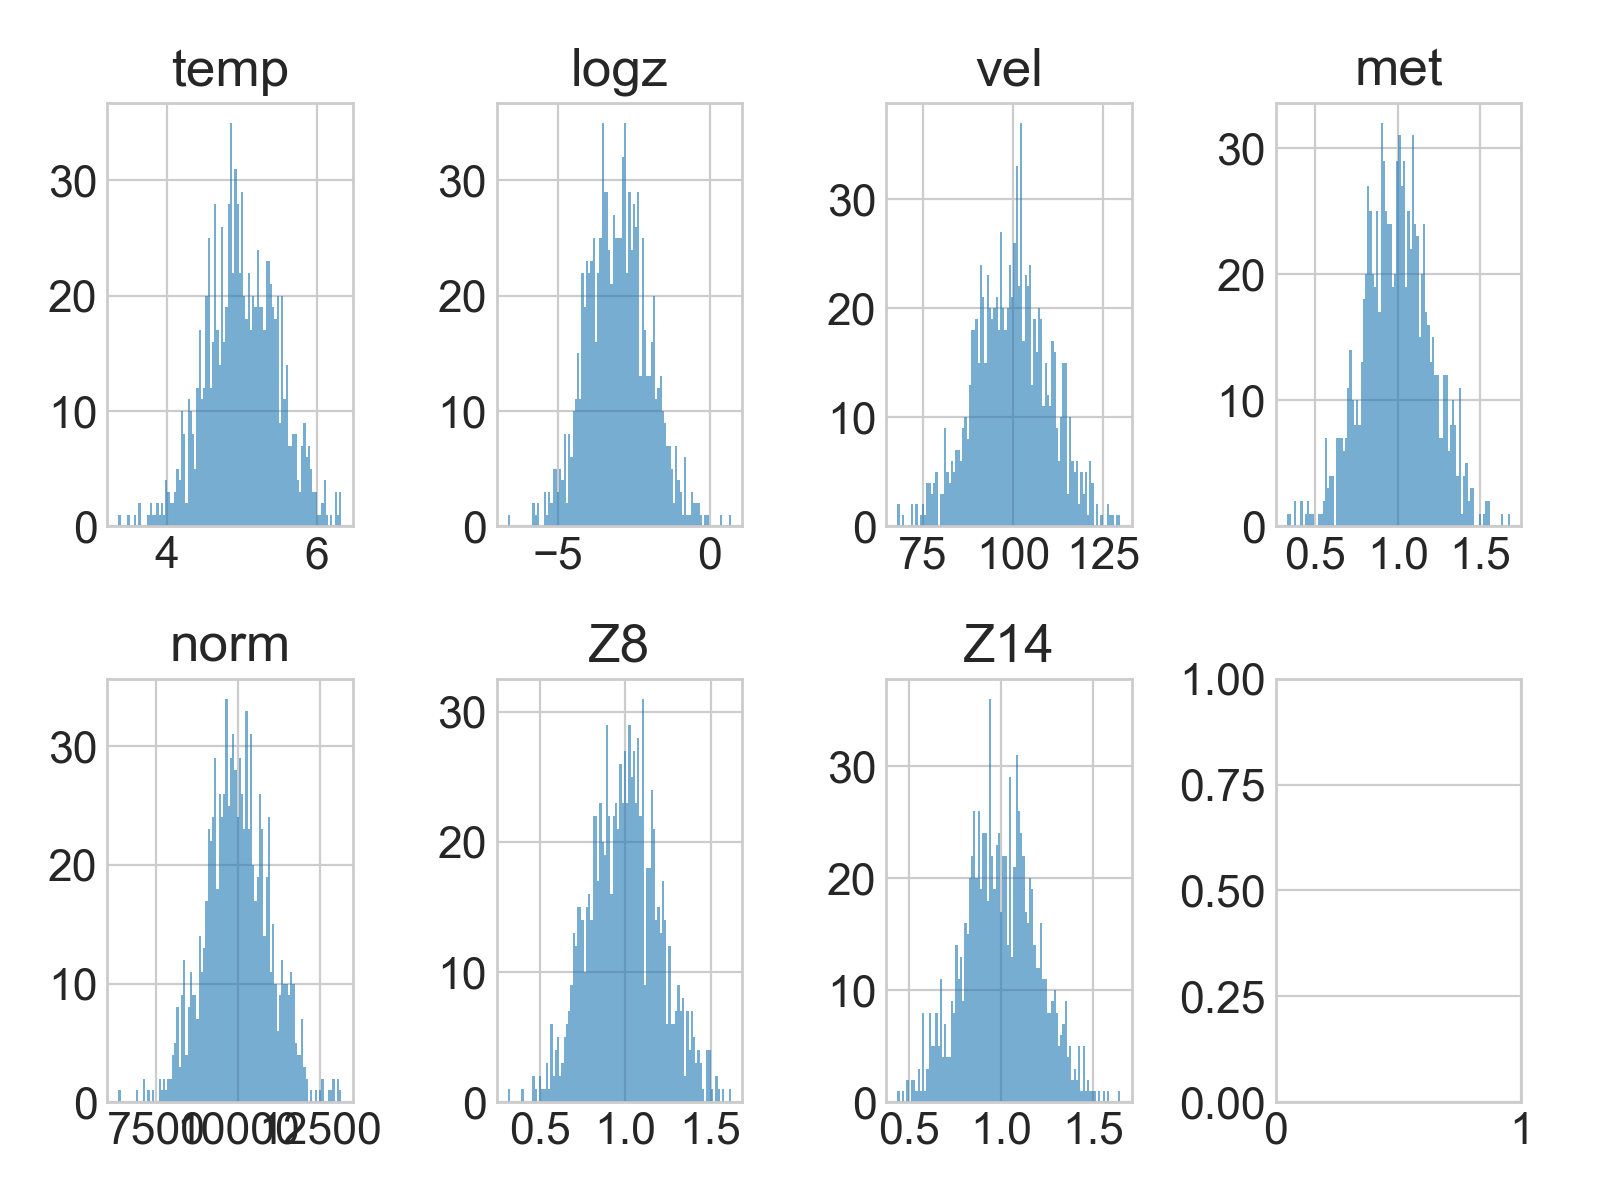

In [262]:
ndim = len(params)
nsamples = 1000

uall = np.random.uniform(size=(nsamples, ndim))

xall = []

for u in uall:
    xall.append(prior_transform(u))
    
xall = np.array(xall)
    
fig, axes = plt.subplots(2, 4, figsize=(8,6))

axes = np.hstack(axes)

for i in range(ndim):
    axes[i].hist(xall[:,i], bins=100, histtype="stepfilled", alpha=0.6)
    axes[i].set_title(list(params.keys())[i])
plt.tight_layout()

Now we can try to run the sampling:

In [263]:
sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim,
                                       bound='balls', sample='rwalk')


In [264]:
sampler.run_nested()

3310it [5:24:38,  5.09s/it, batch: 0 | bound: 21 | nc: 27 | ncall: 59103 | eff(%):  5.553 | loglstar:   -inf < -55114.656 <    inf | logz: -55127.385 +/-  0.157 | dlogz: 1513.735 >  0.010]  Traceback (most recent call last):
  File "/opt/miniconda3/envs/spexai/lib/python3.10/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "/var/folders/cm/2d1tk8fs125435tgbw22nb0h0000gp/T/ipykernel_84236/3925438096.py", line 6, in loglike
    return float(fit.log_likelihood(params))
  File "/Users/daniela/work/repositories/spexai/spexai/inference/fit_new.py", line 246, in log_likelihood
    ymodel = self.combined_model(temp, dict_abund, params['logz'],  params['norm'], params['vel'])
  File "/opt/miniconda3/envs/spexai/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/daniela/work/repositories/spexai/spexai/inference/model.py", lin

Exception while calling loglikelihood function:
  params: [ 4.58827292e+00 -2.00570087e+00  1.08196752e+02  9.96529350e-01
  1.07394020e+04  6.50723619e-01  1.11608508e+00]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


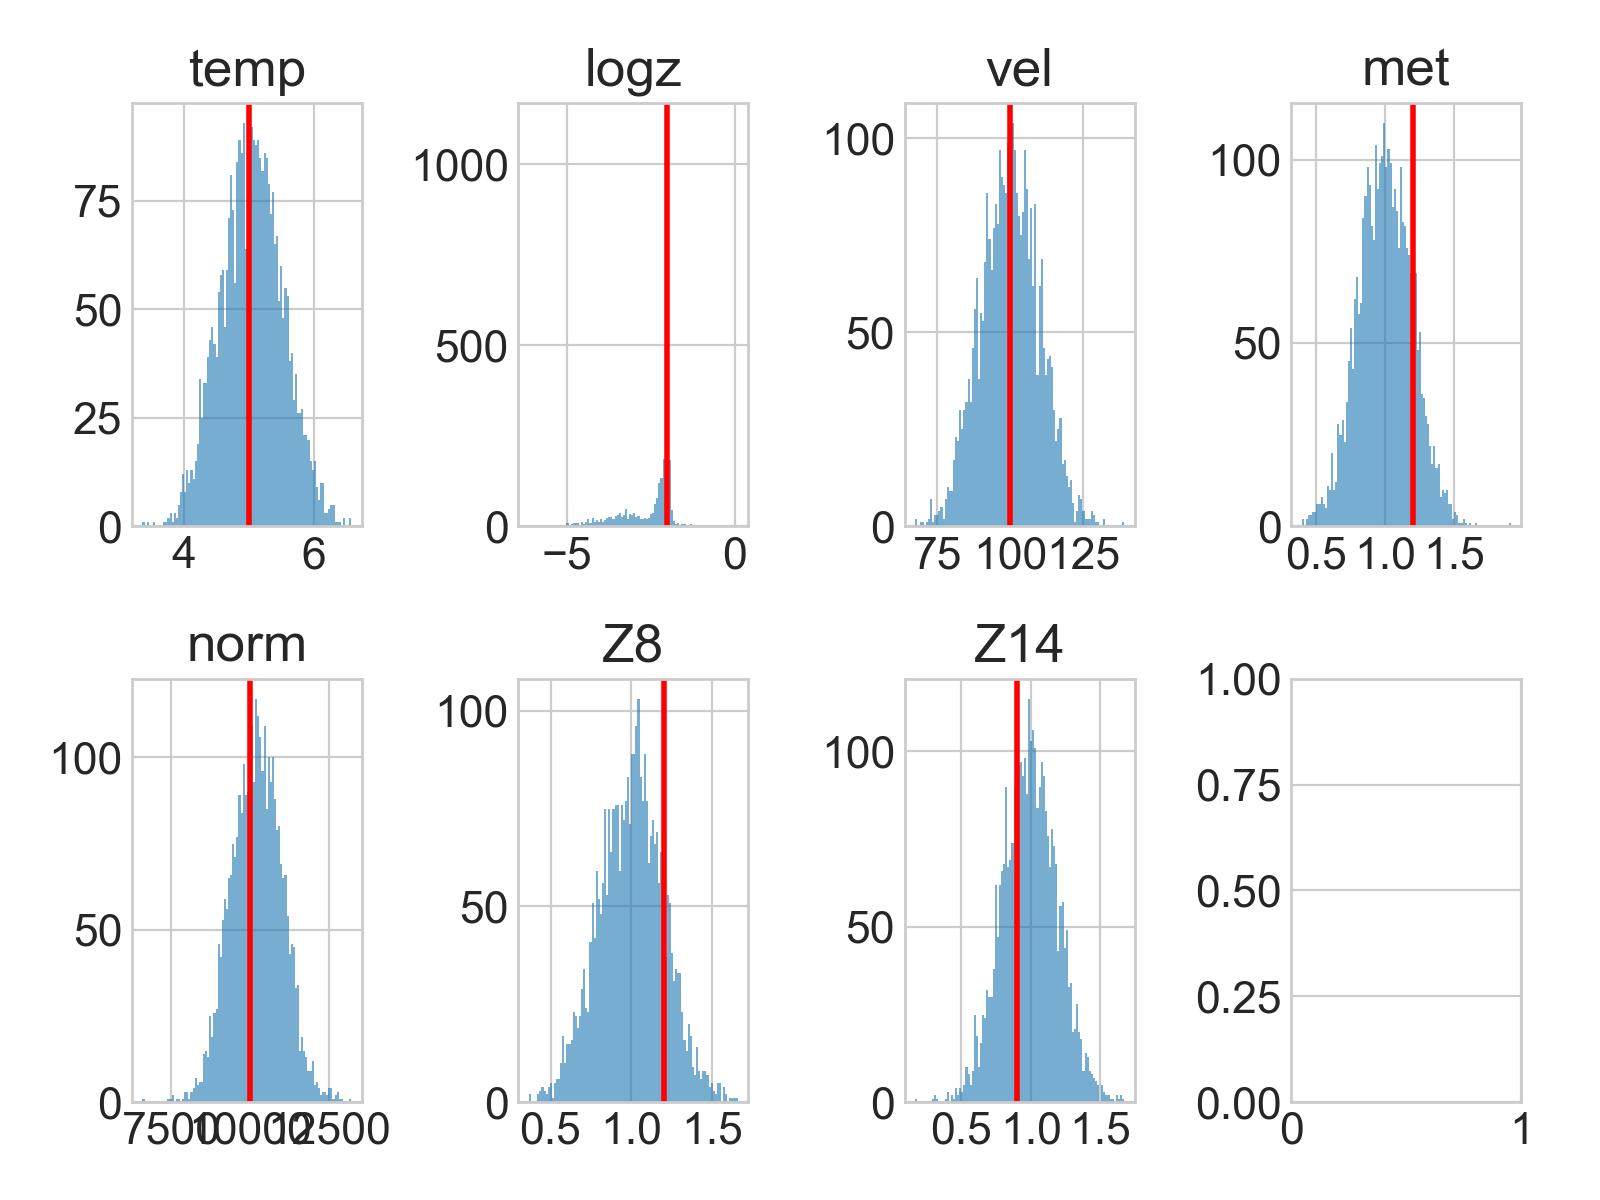

In [272]:
fig, axes = plt.subplots(2, 4, figsize=(8,6))

axes = np.hstack(axes)

for i in range(ndim):
    key = list(params.keys())[i]
    axes[i].hist(sampler.results.samples[:,i], bins=100, histtype="stepfilled", alpha=0.6)
    axes[i].set_title(key)
    axes[i].axvline(params[key], lw=2, color="red")
plt.tight_layout()

In [147]:
l = float(loglike(test_params))

__Add aditional parameters__

Single element abundace that differ with respect to the overall metalicity and Iron can be added in as extra parameter(s).
These are writen in the format ```'ZX'``` with ```X``` the atom number of the elements. ```add_prior``` gives the prior and intial  values of the added paramater(s).

In [19]:
#names of aditional fitted parameters 
add_prior = {'Z8':{'mu':1, 'sigma':.3},'Z14':{'mu':1, 'sigma':.3}}

### Run Ensemble Sampler Fit

Then after ensemble sampler has been fully intialized the data can be fitted with ```Fit.fit_spectra``` making use of ```emcee``` algorithm.
```Fit.fit_spectra``` will also print the integrated autocorrelation time to give an indication of the burn-in time.

In [324]:
#intial guess and prior for fit
full_prior = {
        'temp': {'mu': 5,    'sigma': 1},
        'met' : {'mu': 1.2,    'sigma': .1},
        'vel' : {'mu': 100,  'sigma': 50},
        'logz': {'mu': -2,   'sigma': 0.5},
        'norm': {'mu': 1e4, 'sigma':1e3},
        'Z8':{'mu':1.2, 'sigma':.1},
        'Z14':{'mu':0.9, 'sigma':.1}
        }

In [325]:
#initialize thes
fit = spexai.inference.fit_new.SingleTemp(torch.Tensor(counts), combined_model, full_prior,
                 e_min=None, e_max=15.0, fdir_nn='neuralnetworks/')

Using cpu


In [326]:
np.seterr(all="ignore") #ignore RuntimeWarning error prints
fit.fit_spectrum(20, 1000)

(20, 7)


100%|███████████████████████████████████████████████| 1000/1000 [1:08:33<00:00,  4.11s/it]


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 86.27857088  61.09668365 102.9354286   91.41535435 107.23948613
 106.61761393  83.15500726]

### Evaluating the fit results

The progress of the walker can be visualized in a timeseries giving the parameter values for each walker at each step in the chain.

<IPython.core.display.Javascript object>


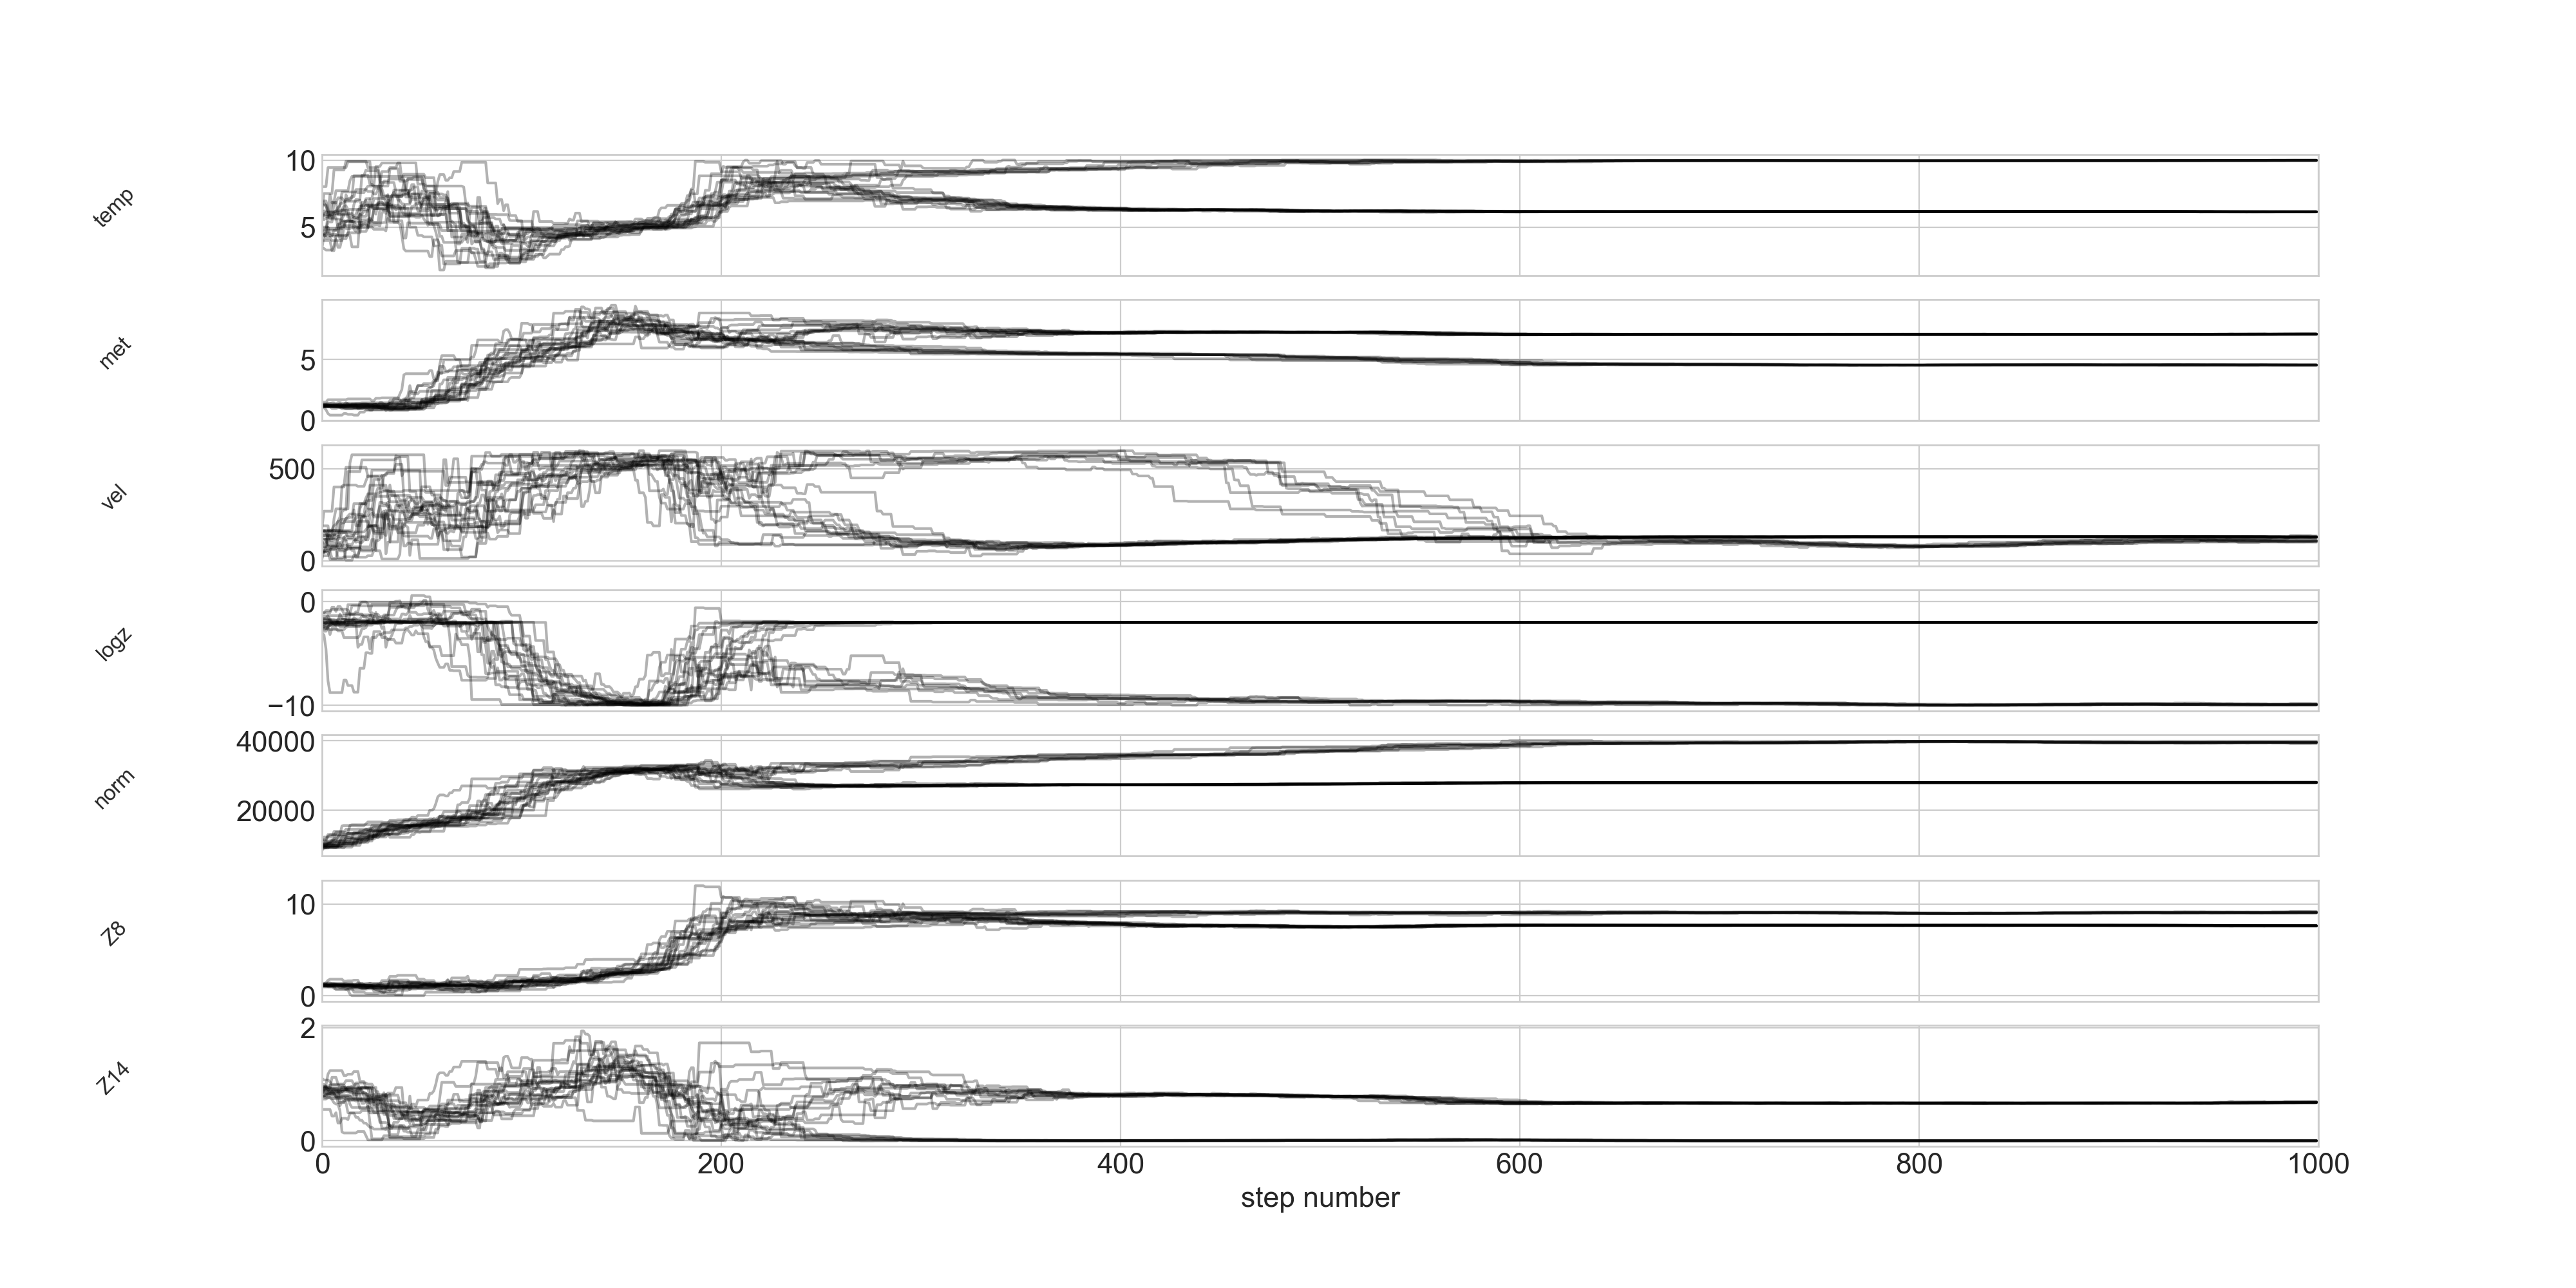

In [327]:
fit.plot_timeseries()

The results of the fit can visualized with a cornerplot. ```Fit.cornerplot``` is also able to save the sampled posterior in an .csv format by giving a directory name ```fitdir```.  In this example you discard the first ```100``` steps in the chain ```discard``` and only reading every 15th step ```thin```. The corner plot can also be oveploted with the true values of the parameters by giving a list ```true_values```, where the values shoud be same order as the prior.

In [328]:
import corner

In [330]:
fit.sampler.chain.shape

(20, 1000, 7)

In [331]:
flatchain = fit.sampler.chain[:,500:, :].reshape((20*500,7))

<IPython.core.display.Javascript object>


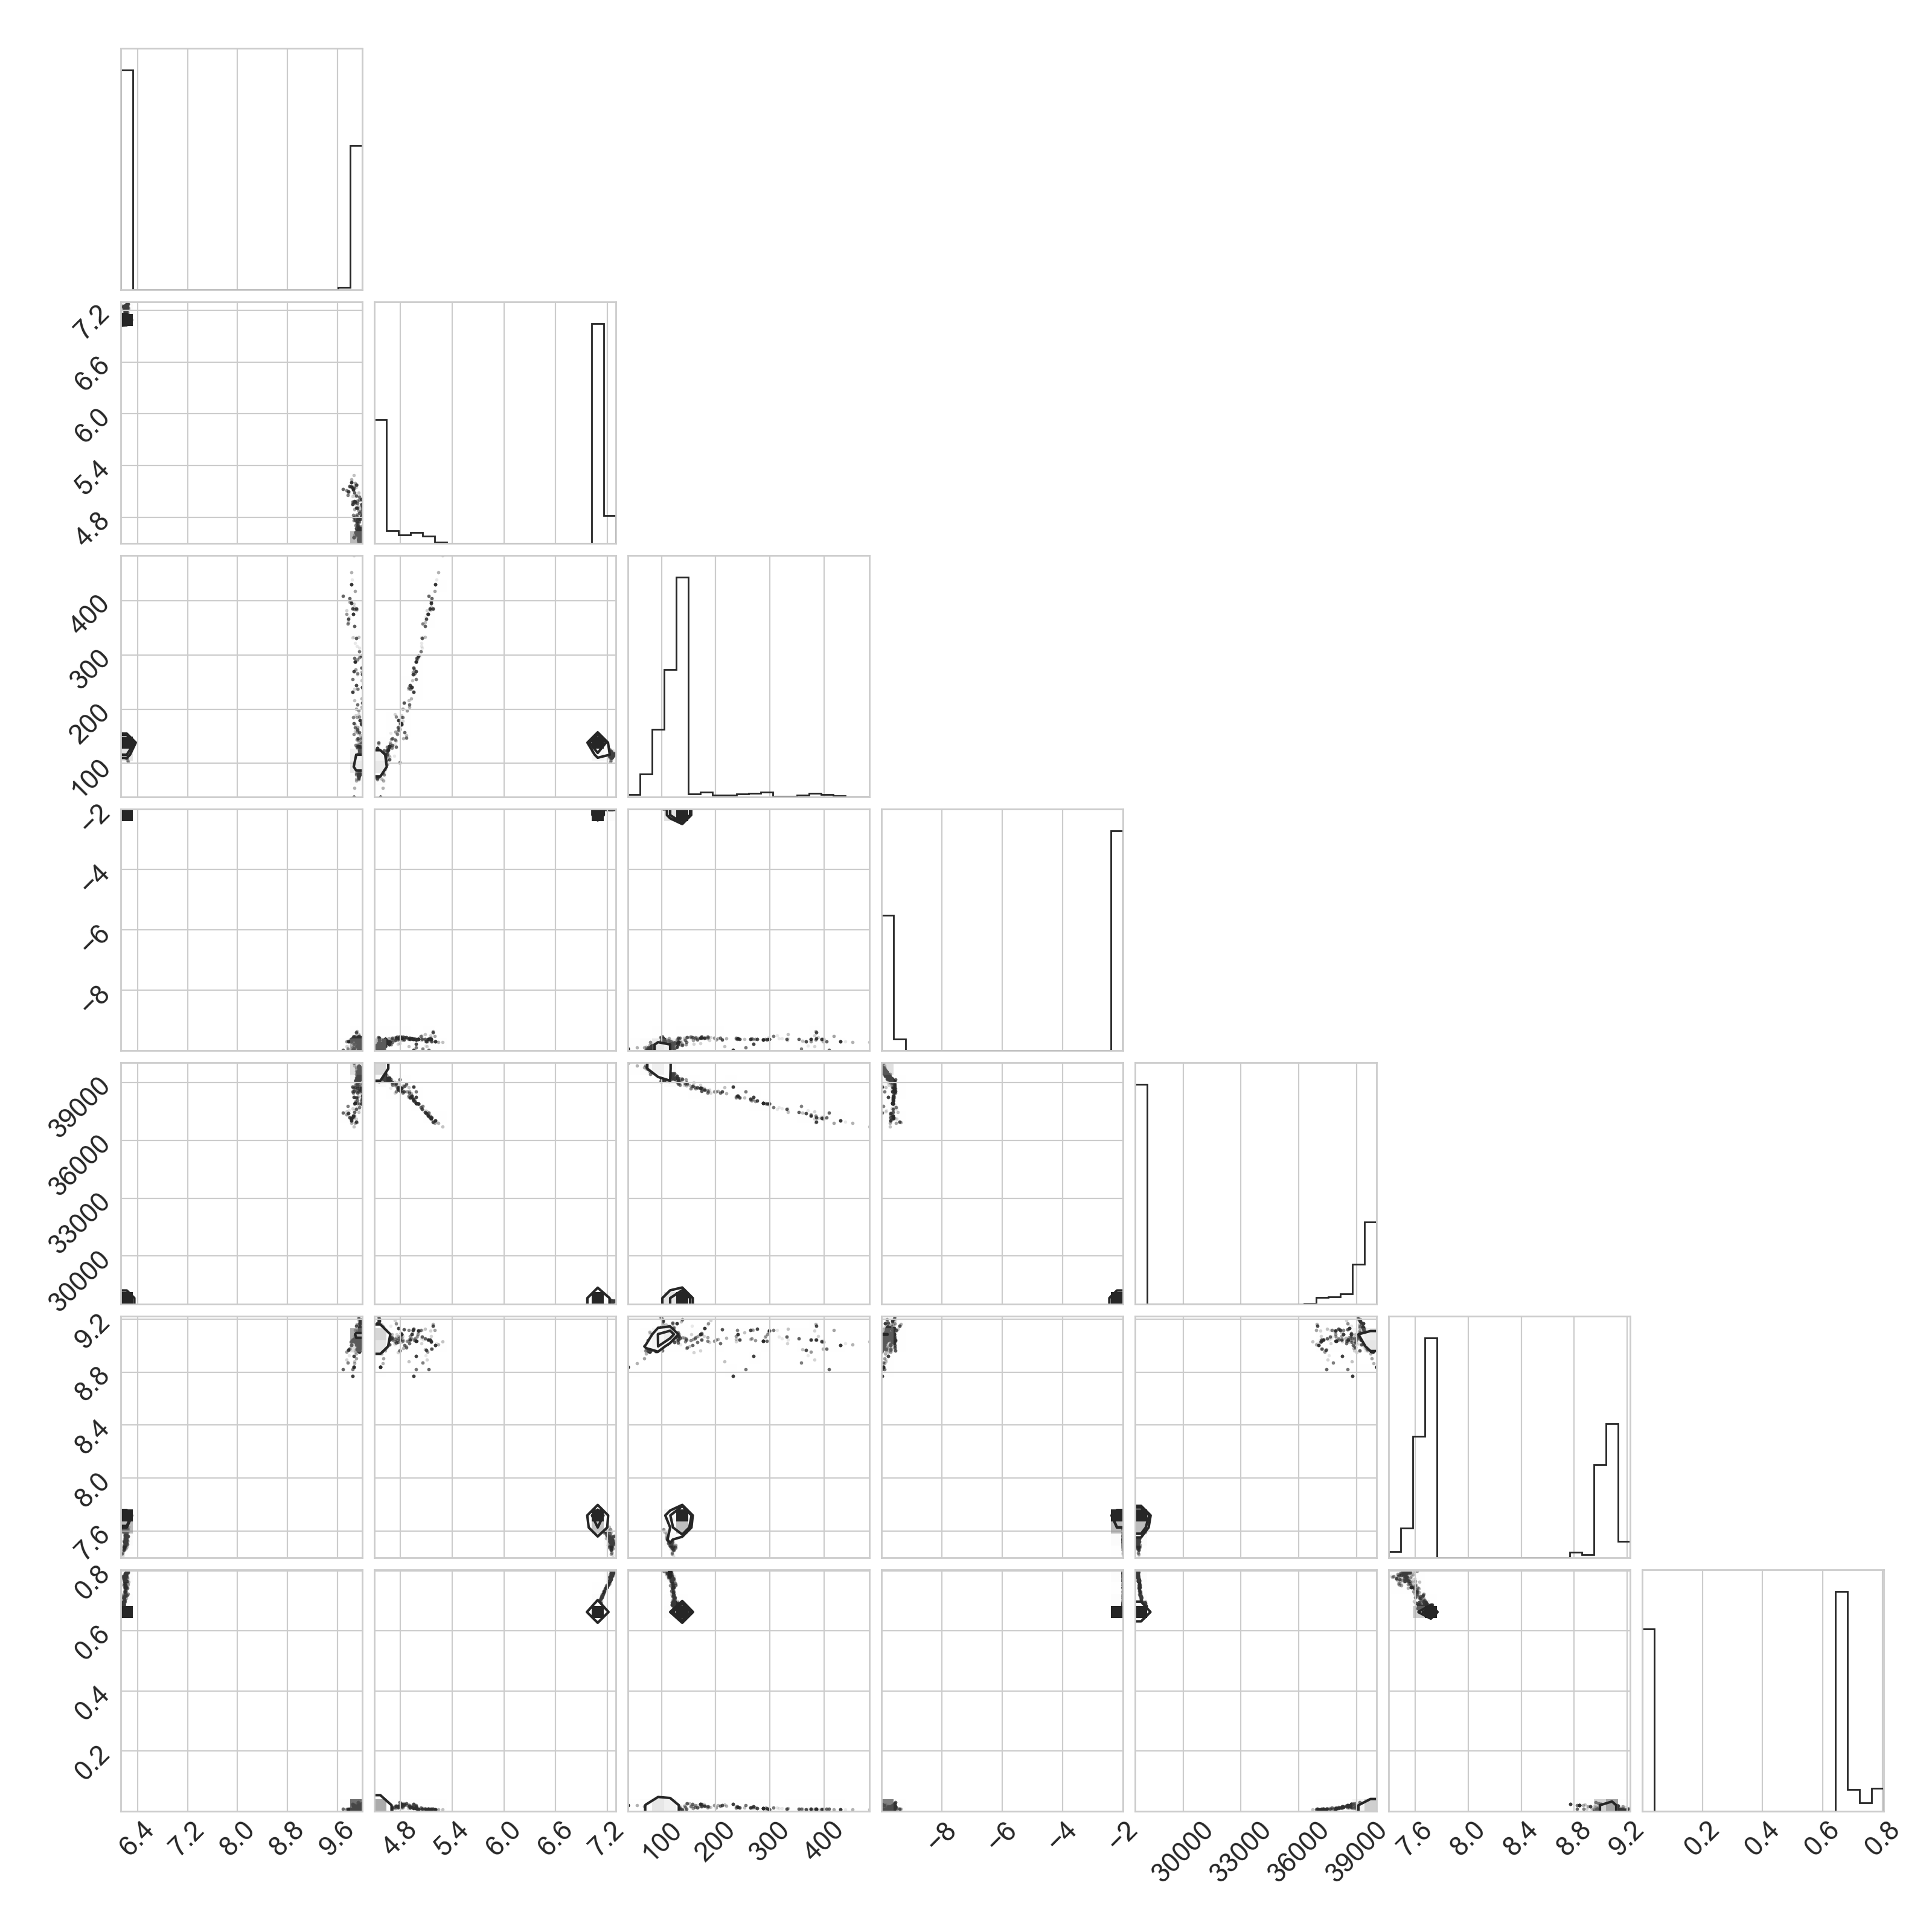

In [332]:
corner.corner(flatchain);

In [280]:
fit.sampler.flatchain

array([[5.50790899e+00, 1.28269373e+00, 1.02171935e+02, ...,
        9.21158030e+03, 7.68538758e-01, 1.08074851e+00],
       [5.40441118e+00, 1.14223986e+00, 9.42690448e+01, ...,
        9.15721252e+03, 9.58856044e-01, 8.97665854e-01],
       [5.15327538e+00, 1.33447562e+00, 1.03851004e+02, ...,
        8.76078877e+03, 1.12967959e+00, 9.53527762e-01],
       ...,
       [4.99755108e+00, 1.20332933e+00, 1.01675310e+02, ...,
        9.98233205e+03, 1.17251501e+00, 9.37580718e-01],
       [5.55352480e+00, 2.87033238e-01, 1.23713685e+02, ...,
        1.19222328e+04, 8.54605489e-01, 9.97505709e-01],
       [4.97124597e+00, 1.19280225e+00, 9.82025274e+01, ...,
        9.98107961e+03, 1.21270306e+00, 9.36459532e-01]])

<IPython.core.display.Javascript object>


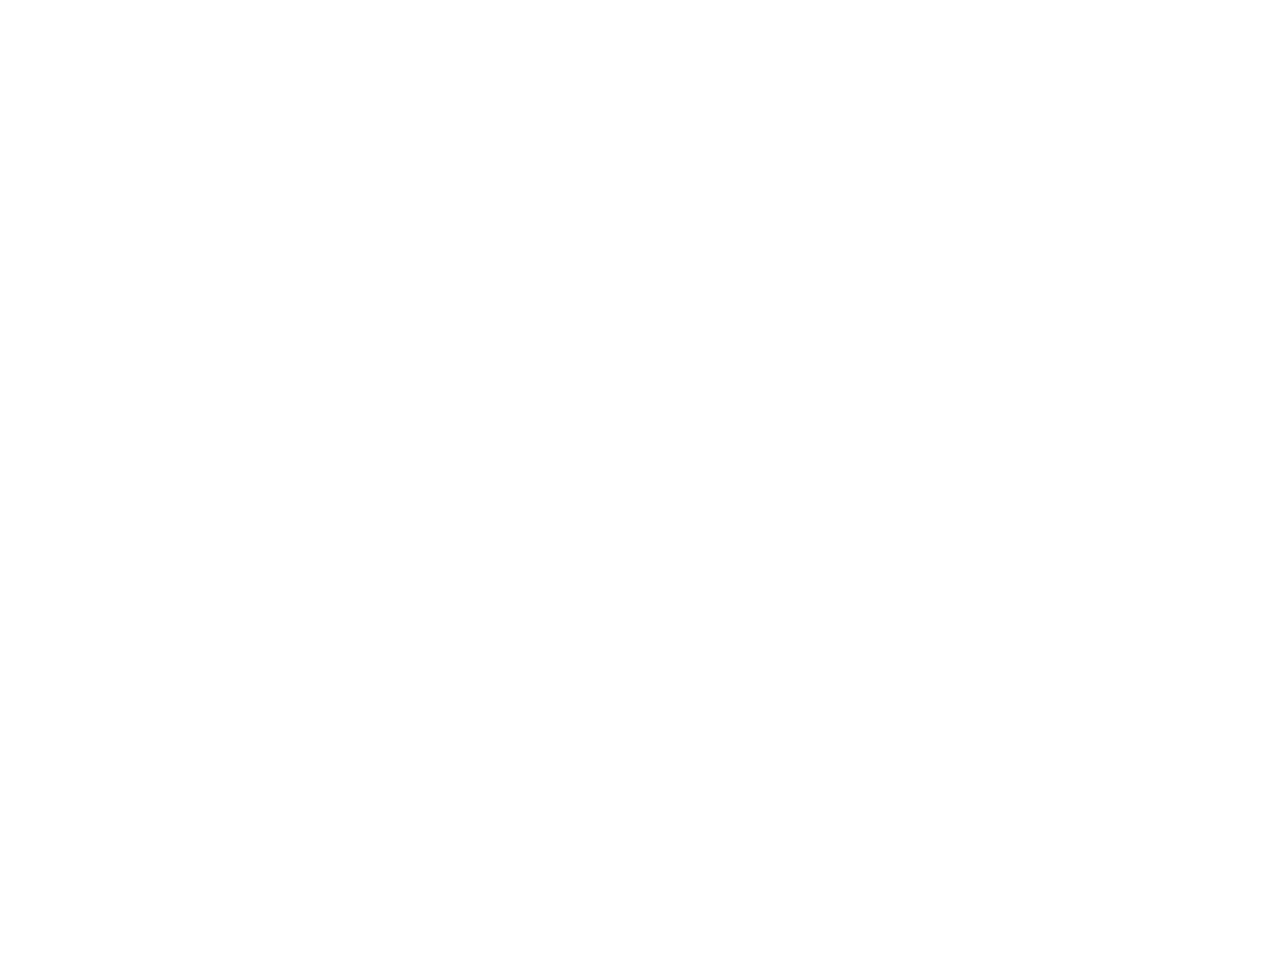

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [333]:
#true_val = [temp,   met,    vel,    logz    norm,   Z8,    Z14]
true_val =  [5,      1,      100,    -2,     1e10,   1.2,   0.9]

fit.cornerplot(600, thin=10, fitdir=None, true_values=true_val)

The fit results can be directly compared to the data by overplotting the fitted model with parameters drawn from the posterior to the observed data, the number of samples it overplots is given by ```nsample```. Also prints the mean and 1-sigma interval of the fitted parameters.

<IPython.core.display.Javascript object>


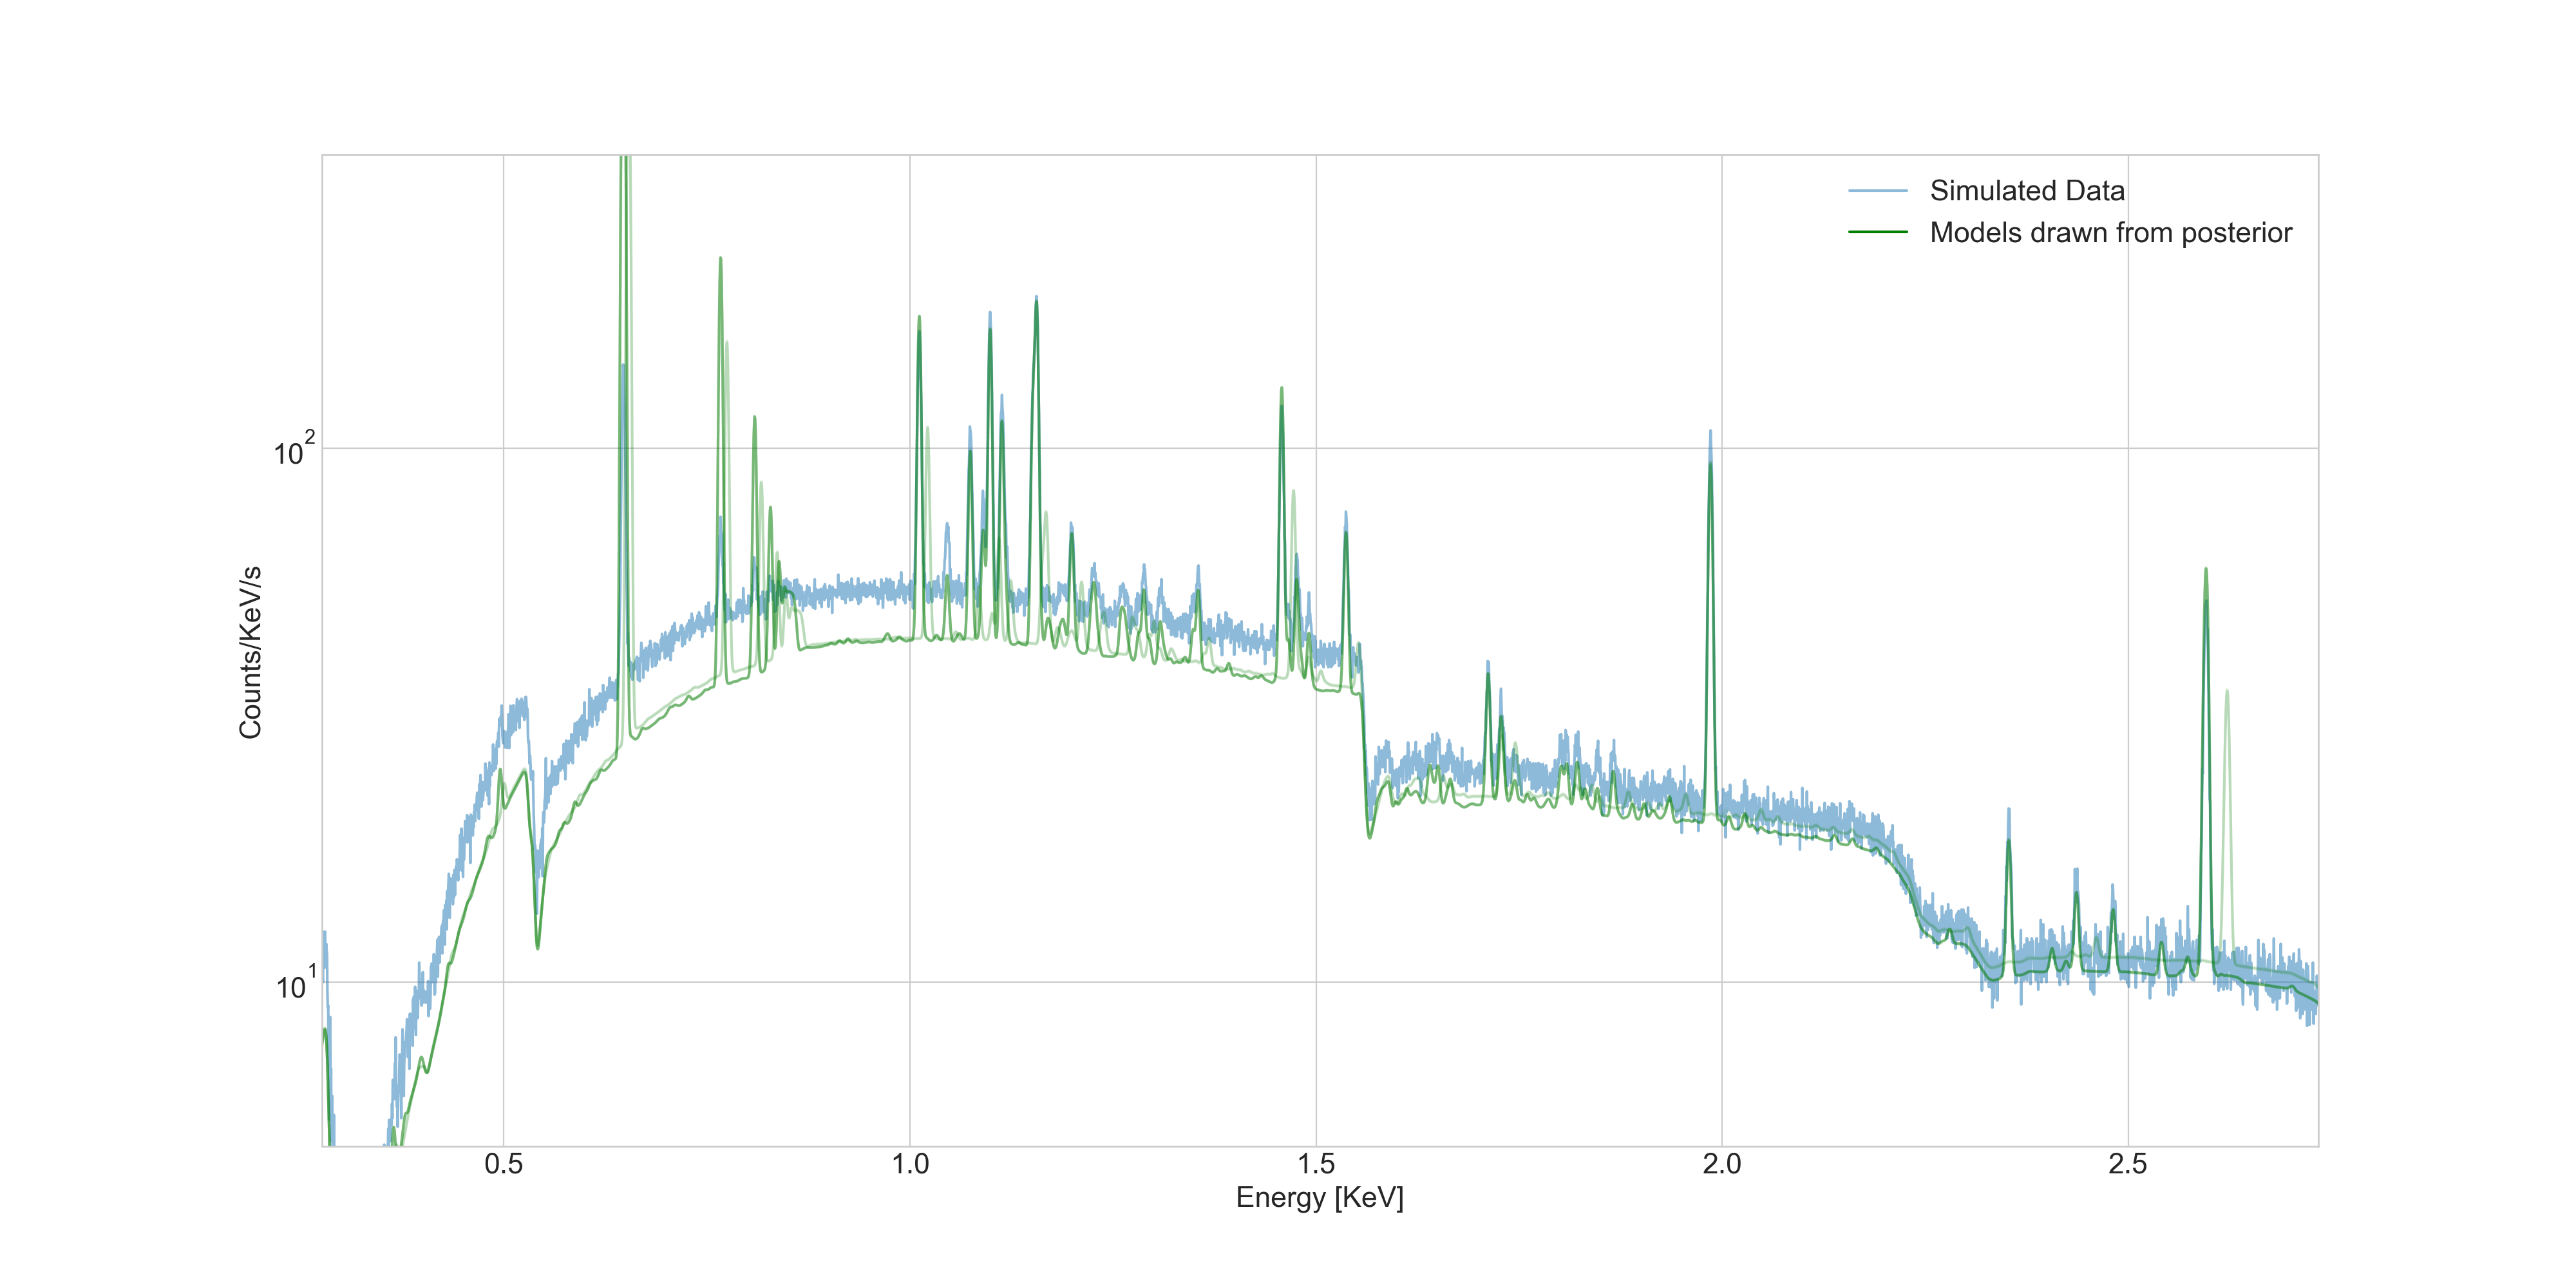

temp = 6.172154543411173_(-0.012595587305946232)^(+3.7864435245307337)
met = 7.066252756861859_(-2.5090707661528038)^(+0.01684993981179339)
vel = 128.22946340311987_(-30.834856211661375)^(+2.6799458056247545)
logz = -1.9994613979955655_(-7.906423946271994)^(+0.00011349716843711555)
norm = 28017.03090921147_(-22.124707820668846)^(+11538.776233660457)
Z8 = 7.693597980592035_(-0.027118104868313786)^(+1.369714968113831)
Z14 = 0.6639454600390278_(-0.6626594834473498)^(+0.00823185180885333)


In [334]:
'''This step can take a long time to run'''
fit.plot_spectrum(nsample=20)

## Fitting a Two-Temperature Model

Simulated data or real data can be model with a one temperuture model by  ```TwoTemp``` a subclass of Fit

The paramater that are fitted are the 
- First temperature in KeV  ```temp1``` (between 0.2 and 10 KeV)
- Second temperature in KeV  ```temp2``` (between 0.2 and 10 KeV)
- Metalicity [Z_solar] ```met```  (larger then 0)
- Turbulent velocity in km/sec ```vel``` (between 0 and 600 km/sec)
- Redshift in log10(z) ```logz``` (between -10 and 1)
- First normalisation ```norm1``` (between 1e5 and 1e15)
- Second normalisation ```norm2``` (between 1e5 and 1e15)

Additional parameter(s)
- Single element ```X``` abundace ratio with respect to Iron ```ZX```, where ```X``` is tha atom number (larger then 0)

The intial guess with there standard diviation of all the parameters that are fitted can be put into the dictiornary of the ```prior```.

In [ ]:
#intial guess and prior for fit
prior = {
        'temp1': {'mu': 4.5,    'sigma': 2},
        'temp2': {'mu': 6,    'sigma': 2},
        'met' : {'mu': 1,    'sigma': .3},
        'vel' : {'mu': 100,  'sigma': 50},
        'logz': {'mu': -5,   'sigma': 2},
        'norm1': {'mu': 1e10, 'sigma': 5e9},
        'norm2': {'mu': 1.5e10, 'sigma': 5e9}
        }

The ensemble samper can be intialized with ```nwalkers``` and ```nsteps``` for the walker to go through, ```prior``` indicates the intial values for the parameters and there Gaussion prior in the likelihood, other parameter that can be initialized are the Luminosity Distance in m and the energy interval of the spectrum in KeV (```e_min``` > 0.1; ```e_max``` < 25).

```fdir_nn``` is the file directory to the trained neural networks and should match the path on your device.

In [ ]:
#initialize the
fit_2t = TwoTemp(50, 800, prior, Luminosity_Distance=1e25, fdir_nn='/home/jmatthijss/spexai_code/neuralnetworks/', e_max=15)

### Reading in the FITS files

To be able to fit real data the response of the telescope can be read in by the FITS file, for the Response Matrix File (RMF), effective area response file (ARF).

The data used for fitting can be read in from a FITS file of the observed data ```TwoTemp.load_data```, or can be simulated by the model with ```TwoTemp.sim_data(params)``` here ```params``` is a dictornary with the parameter names and there values.

In addition the response files there is a sparse matrix (```make_sparsex```) used for convulation that implements line broadening to the spectra. The speed an accuracy of the line broadening is strongly dependent on the kernel size of the convulolution ```n``` and the default ```n=300```, increasing ```n``` will make the line-broading more accurete but will also segnifcanly impact the speed.

In [ ]:
'''This step can take a long time to run'''
#reading in the response matrix file
fit_2t.combined_model.load_rm('/home/jmatthijss/obs234_HP_obs234_all_det/obs234_HP_obs234_all_det_he.rmf')

In [ ]:
#reading in the effective area
fit_2t.combined_model.load_arf('/home/jmatthijss/obs234_HP_obs234_all_det/obs234_HP_obs234_all_det_point_he.arf')

In [ ]:
'''This step can take a long time to run'''
#initializing the sparse matrix for the convolution from line-broadening
fit_2t.combined_model.load_sparsematrix_x(n=200)

In [ ]:
#create your own data
params = {'temp1':4, 'temp2':5.8, 'logz':-2, 'vel':100, 'met':1.2, 'norm1':8e9, 'norm2':1.2e10}
fit_2t.sim_data(params, exp_time=50000)

__Add aditional parameters__

Single element abundace that differ with respect to the overall metalicity and Iron can be added in as extra parameter(s).
These are writen in the format ```'ZX'``` with ```X``` the atom number of the elements. ```add_prior``` gives the prior and intial  values of the added paramater(s).

In [ ]:
#names of aditional fitted parameters 
add_prior = {'Z8':{'mu':1, 'sigma':.3},'Z14':{'mu':1, 'sigma':.3}}

### Run Ensemble Sampler Fit

Then after ensemble sampler has been fully intialized the data can be fitted with ```Fit.fit_spectra``` making use of ```emcee``` algorithm.
```TwoTemp.fit_spectra``` will also print the integrated autocorrelation time to give an indication of the burn-in time.

In [ ]:
'''This step can take a long time to run'''
np.seterr(all="ignore")#ignore RuntimeWarning error prints
fit_2t.fit_spectra(add_prior=add_prior)

### Evaluating the fit results

The progress of the walker can be visualized in a timeseries giving the parameter values for each walker at each step in the chain.

In [ ]:
fit_2t.plot_timeseries()

The results of the fit can visualized with a cornerplot. ```TwoTemp.cornerplot``` is also able to save the sampled posterior in an .csv format by giving a directory name ```fitdir```.  In this example you discard the first ```100``` steps in the chain ```discard``` and only reading every 15th step ```thin```. The corner plot can also be oveploted with the true values of the parameters by giving a list ```true_values```, where the values shoud be same order as the prior.

In [ ]:
#true_val = [temp1, temp2,  met,    vel,    logz    norm1,  norm2,  Z8,    Z14]
true_val =  [4,     5.8,    1,      100,    -2,     8e9,    1.2e10, 1.2,   0.9]

fit_2t.cornerplot(600, thin=10, fitdir=None, true_values=true_val)

The fit results can be directly compared to the data by overplotting the fitted model with parameters drawn from the posterior to the observed data, the number of samples it overplots is given by ```nsample```. Also prints the mean and 1-sigma interval of the fitted parameters.

In [ ]:
'''This step can take a long time to run'''
fit_2t.plot_spectrum(nsample=20)

## Fitting a Multi-Temperature Distribution Model

This uses a Subclass of ```Fit```, ```TempDist``` to fit a model with a multi-temperature distribution.

The temperature need to give a function that outputs a temperature grid and temperature distribution described by parameters. The output of the temperature grid should always be inbetween 0.2 and 10 KeV and linearly spaced and the distribution should always be normalized.

In this exapmle we look at a Normal Distribution for our temperature distribution, parametrized by a mean temperature and standard devitation.

The paramater that are fitted
- Mean Temperature in KeV ```mean_temp``` (between 0.2 and 10)
- Standard divation of Temperature in log(KeV) ```log_sd_temp``` (between -5, 0.3)
- Metalicity [Z_solar] ```met```  (larger then 0)
- Turbulent velocity in km/sec ```vel``` (between 0 and 600 km/sec)
- Redshift in log10(z) ```logz``` (between -10 and 1)
- Normalisation ```norm``` (between 1e5 and 1e15)

Additional parameter(s)
- Single element ```X``` abundace ratio with respect to Iron ```ZX```, where ```X``` is tha atom number (larger then 0)

The intial guess with there standard diviation can be put into the dictiornary of the ```prior```.

In [ ]:
def normal_dist(params):
    '''
    Normal Distribution with stdev in logspace
    Parameters
    ----------
    params: dict
        dictionary with the keys of distribution parameters
        in this case 'mean_temp' and 'log_sd_temp'
    '''
    #intialize temperature grid
    low = max(params['mean_temp']-5*10**params['log_sd_temp'], 0.2)
    high = min(params['mean_temp']+5*10**params['log_sd_temp'], 10)
    temp_grid = np.linspace(low, high,  500)
    
    #Gaussion distribution
    mean = params['mean_temp']
    sd = 10**params['log_sd_temp']
    temp_dist = 1/(np.sqrt(2*np.pi)*sd**2) * np.exp(-0.5*((temp_grid-mean)/sd)**2)
    
    #normalize the function 
    temp_dist = temp_dist/np.sum(temp_dist*np.mean(np.diff(temp_grid)))
    return temp_grid, temp_dist

#define allowed interval of parameter of the distribution
interval = {
            'mean_temp': [0.2,10],
            'log_sd_temp'  : [-5, 0.3]
           }

The intial guess with there standard diviation of all the parameters that are fitted can be put into the dictiornary of the ```prior```.

In [ ]:
#intial guess and prior for temp run
prior = {
        'mean_temp': {'mu': 4, 'sigma': 1},
        'log_sd_temp'  : {'mu': 0, 'sigma': 1},
        'met'      : {'mu': 0.6, 'sigma': .3},
        'vel'      : {'mu': 160, 'sigma': 25},
        'logz'     : {'mu': np.log10(0.017284),  'sigma': 0.05},
        'norm'     : {'mu': 2e10, 'sigma': 1e9}
        }

The ensemble samper can be intialized with ```nwalkers``` and ```nsteps``` for the walker to go through, the prior ```prior```, for the TempDist we need to give the function that returns a normalized temperature distribution with the temperature grid ```normal_dist``` and the bound interval of this ditributions parameter ```interval```, other parameter that can be initialized are the Luminosity Distance in m and the energy interval of the spectrum in KeV (```e_min, e_max```).

In [ ]:
#initialize the
fit_dist = TempDist(40, 2, prior, normal_dist, interval, Luminosity_Distance=9.461e24, e_min=2, e_max=9, fdir_nn='/home/jmatthijss/spexai_code/neuralnetworks/')

### Reading in the FITS files

To be able to fit real data the response of the telescope can be read in by the FITS file, for the Response Matrix File (RMF), effective area response file (ARF) and the FITS file of the observed data.

In addition the response files there is a sparse matrix (```make_sparsex```) used for convulation that implements line broadening to the spectra. The speed an accuracy of the line broadening is strongly dependent on the kernel size of the convulolution ```n``` and the default ```n=300```, increasing ```n``` will make the line-broading more accurete but will also segnifcanly impact the speed.

In [ ]:
'''This step can take a long time to run'''
#reading in the response matrix file
fit_dist.combined_model.load_rm('/home/jmatthijss/obs234_HP_obs234_all_det/obs234_HP_obs234_all_det_he.rmf')

In [ ]:
#reading in the effective area
fit_dist.combined_model.load_arf('/home/jmatthijss/obs234_HP_obs234_all_det/obs234_HP_obs234_all_det_point_he.arf')

In [ ]:
'''This step can take a long time to run'''
#initializing the sparse matrix for the convolution from line-broadening
fit_dist.combined_model.load_sparsematrix_x(n=200)

Now instead of simulating the data we are reading it in from a FITS file

In [ ]:
#reading in the data
fit_dist.load_data('/home/jmatthijss/obs234_HP_obs234_all_det/obs234_HP_obs234_all_det_valign_gcor_he.pi')


#### Add aditional parameters

Single element abundace that differ with respect to the overall metalicity and Iron can be added in as extra parameter(s).
These are writen in the format ```'ZX'``` with ```X``` the atom number of the elements. ```add_prior``` gives the prior and intial  values of the added paramater(s).

In [ ]:
#names of aditional fitted parameters 
add_prior = {'Z8':{'mu':1, 'sigma':.3},'Z14':{'mu':1, 'sigma':.3}}

Then after ensemble sampler has been fully intialized the data can be fitted with ```TempDist.fit_spectra``` making use of ```emcee``` algorithm.
```TempDist.fit_spectra``` will aslo print the the integrated autocorrelation time to give an indication of the burn-in time.

In [ ]:
import torch
import matplotlib.pyplot as plt
def normal_dist(x , mean , sd):
    sd = torch.tensor(sd, dtype=torch.float32, device=x.device)
    prob_density = 1/(torch.sqrt(torch.tensor(2*np.pi, dtype=torch.float32, device=x.device)*sd**2)) * torch.exp(-0.5*((x-torch.tensor(mean, dtype=torch.float32, device=x.device))/sd)**2)
    return prob_density

In [ ]:
params = {'Temperature [KeV]': 4, 'Temp Stdev log[KeV]': -2, 'Redshift [log(z)]': np.log10(0.017284), 'Velocity [km/sec]': 160, 'Metalicity [Fe/H]': .7, 'Normalisation': 2e10}

dict_abund = {}
for i in torch.arange(6,31):
    dict_abund[f'Z{i}'] = params['Metalicity [Fe/H]']
    for key in params.keys():
        if key == f'Z{i} [Z{i}/Fe]':
            dict_abund[f'Z{i}'] = params['Metalicity [Fe/H]']*params[f'Z{i} [Z{i}/Fe]']
low = max(params['Temperature [KeV]']-5*10**params['Temp Stdev log[KeV]'], 0.1)
high = min(params['Temperature [KeV]']+5*10**params['Temp Stdev log[KeV]'],10)
temp_grid = torch.linspace(low, high, 500, dtype=torch.float32, device='cuda')
temp_dist = normal_dist(temp_grid, params['Temperature [KeV]'], 10**params['Temp Stdev log[KeV]'])
temp_dist = temp_dist/torch.sum(temp_dist*torch.mean(torch.diff(temp_grid)))
with torch.no_grad():
    ymodel = fit_dist.combined_model(temp_grid, temp_dist, dict_abund, params['Redshift [log(z)]'], 
                    params['Normalisation'], params['Velocity [km/sec]'])
plt.plot(ymodel[fit_dist.intv].cpu().detach())
plt.yscale('log')
plt.ylim(1e-2,1e1)



In [ ]:
'''This step can take a long time to run'''
np.seterr(all="ignore")#ignore RuntimeWarning error prints
fit_dist.fit_spectra(add_prior=add_prior)

### Evaluating the fit results

The progress of the walker can be visualized in a timeseries giving the parameter values for each walker at each step in the chain.

In [ ]:
fit_dist.plot_timeseries()

The results of the fit can visualized with a cornerplot. ```TempDist.cornerplot``` is also able to save the sampled posterior in an .csv format by giving a directory name ```fitdir```.  In this example you discard the first ```100``` steps in the chain ```discard``` and only reading every 15th step ```thin```. The corner plot can also be oveploted with the true values of the parameters by giving a list ```true_values```, where the values shoud be same order as the prior.

In [ ]:
#true_val = mean_temp,  log_sd_temp,    met,    vel,    logz    norm,   Z8, Z14

fit_dist.cornerplot(1, thin=1, fitdir=None, true_values=None)

The fit results can be directly compared to the data by overplotting the fitted model with parameters drawn from the posterior to the observed data, the number of samples it overplots is given by ```nsample```. Also prints the mean and 1-sigma interval of the fitted parameters.

In [ ]:
'''This step can take a long time to run'''
fit_dist.plot_spectrum(nsample=20)